# Business problem overview


In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

 

For many incumbent operators, retaining high profitable customers is the number one business goal.

 

To reduce customer churn, telecom companies need to predict which customers are at high risk of churn.

 

In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.


***This project is based on the Indian and Southeast Asian Prepaid market.***

Churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully.  Also, prepaid is the most common model in India and Southeast Asia, while postpaid is more common in Europe in North America.


***In this project, you will use the usage-based definition to define churn.***

Usage-based churn: Customers who have not done any usage, either incoming or outgoing - in terms of calls, internet etc. over a period of time.



# Understanding customer behaviour during churn

Customers usually do not decide to switch to another competitor instantly, but rather over a period of time (this is especially applicable to high-value customers). In churn prediction, we assume that there are three phases of customer lifecycle :

***The ‘good’ phase***: In this phase, the customer is happy with the service and behaves as usual.

***The ‘action’ phase***: The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a  competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. Also, it is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

***The ‘churn’ phase***: In this phase, the customer is said to have churned. You define churn based on this phase. Also, it is important to note that at the time of prediction (i.e. the action months), this data is not available to you for prediction. Thus, after tagging churn as 1/0 based on this phase, you discard all data corresponding to this phase.

 

In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.



# Modelling

Build models to predict churn. The predictive model that you’re going to build will serve two purposes:

- It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

- It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

 




 

# Steps to derive predictive model:

- Preprocess data (convert columns to appropriate formats, handle missing values, etc.)

- Conduct appropriate exploratory analysis to extract useful insights (whether directly useful for business or for eventual modelling/feature engineering).

- Derive new features.

- Reduce the number of variables using PCA.

- Train a variety of models, tune model hyperparameters, etc. (handle class imbalance using appropriate techniques).

- Evaluate the models using appropriate evaluation metrics. Note that it is more important to identify churners than the non-churners accurately - choose an appropriate evaluation metric which reflects this business goal.

- Finally, choose a model based on some evaluation metric.

 

# 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import sklearn.preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

pd.set_option("display.max_columns", 900)
pd.set_option("display.max_rows", 900)

# 2. Read Data

### 2.1 Read the data dictionary

In [2]:
data_dict = pd.read_excel('Data+Dictionary-+Telecom+Churn+Case+Study.xlsx')
data_dict.head()

Acronyms                                           Descriptions
0  MOBILE_NUMBER                              Customer phone number
1      CIRCLE_ID  Telecom circle area to which the customer belo...
2            LOC           Local calls - within same telecom circle
3            STD             STD calls - outside the calling circle
4             IC                                     Incoming calls

### 2.2 Read the database

In [3]:
churn = pd.read_csv("telecom_churn_data.csv")
churn.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9   arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  \
0            9/30/2014  197.385  214.816  213.803   21.100          NaN   
1            9/30/2014   34.047  355.074  268.321   86.285        24.11   
2            9/30/2014  167.690  189.058  210.226  290.714        11.54   
3            9/30/2014  221.338  251.102  508.054  389.500        99.91   
4            9/30/2014  261.636  309.876  238.174  163.426        50.31   

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0          NaN         0.00          NaN           NaN           NaN   
1        78.68         7.68        18.34         15.74         99.84   
2        55.24        37.26        74.81        143.33        220.59   
3        54.39       310.98       241.71        123.31        109.01   
4       149.44        83.89        58.78         76.96         91.88   

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0          0.00           NaN            NaN            NaN           0.00   
1        304.76         53.76            0.0           0.00           0.00   
2        208.36        118.91            0.0           0.00           0.00   
3         71.68        113.54            0.0          54.86          44.38   
4        124.26         45.81            0.0           0.00           0.00   

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            NaN            NaN            NaN           0.00            NaN   
1           0.00            0.0           0.00           0.00           0.00   
2          38.49            0.0           0.00           0.00          70.94   
3           0.00            0.0          28.09          39.04           0.00   
4           0.00            0.0           0.00           0.00           0.00   

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               NaN               NaN              0.00               NaN   
1             23.88             74.56              7.68             18.34   
2              7.19             28.74             13.58             14.39   
3             73.68             34.81             10.61             15.49   
4             50.31            149.44             83.89             58.78   

   loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               NaN               NaN              0.00               NaN   
1             11.51             75.94            291.86             53.76   
2             29.34             16.86             38.46             28.16   
3            107.43             83.21             22.46             65.46   
4             67.64             91.88            124.26             37.89   

   loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               NaN               NaN              0.00               NaN   
1              0.00              0.00              0.00              0.00   
2             24.11             21.79             15.61             22.24   
3              1.91              0.65              

# 3. Understand Data

In [4]:
# no of rows and columns
churn.shape

(99999, 226)

In [5]:
# get info of each column
churn.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    mobile_number             99999 non-null  int64  
 1    circle_id                 99999 non-null  int64  
 2    loc_og_t2o_mou            98981 non-null  float64
 3    std_og_t2o_mou            98981 non-null  float64
 4    loc_ic_t2o_mou            98981 non-null  float64
 5    last_date_of_month_6      99999 non-null  object 
 6    last_date_of_month_7      99398 non-null  object 
 7    last_date_of_month_8      98899 non-null  object 
 8    last_date_of_month_9      98340 non-null  object 
 9    arpu_6                    99999 non-null  float64
 10   arpu_7                    99999 non-null  float64
 11   arpu_8                    99999 non-null  float64
 12   arpu_9                    99999 non-null  float64
 13   onnet_mou_6               96062 non-null  fl

In [6]:
# get statistical data information
churn.describe().T

count          mean            std           min  \
mobile_number       99999.0  7.001207e+09  695669.386290  7.000000e+09   
circle_id           99999.0  1.090000e+02       0.000000  1.090000e+02   
loc_og_t2o_mou      98981.0  0.000000e+00       0.000000  0.000000e+00   
std_og_t2o_mou      98981.0  0.000000e+00       0.000000  0.000000e+00   
loc_ic_t2o_mou      98981.0  0.000000e+00       0.000000  0.000000e+00   
arpu_6              99999.0  2.829874e+02     328.439770 -2.258709e+03   
arpu_7              99999.0  2.785366e+02     338.156291 -2.014045e+03   
arpu_8              99999.0  2.791547e+02     344.474791 -9.458080e+02   
arpu_9              99999.0  2.616451e+02     341.998630 -1.899505e+03   
onnet_mou_6         96062.0  1.323959e+02     297.207406  0.000000e+00   
onnet_mou_7         96140.0  1.336708e+02     308.794148  0.000000e+00   
onnet_mou_8         94621.0  1.330181e+02     308.951589  0.000000e+00   
onnet_mou_9         92254.0  1.303023e+02     308.477668  0.000000e+00   
offnet_mou_6        96062.0  1.979356e+02     316.851613  0.000000e+00   
offnet_mou_7        96140.0  1.970451e+02     325.862803  0.000000e+00   
offnet_mou_8        94621.0  1.965748e+02     327.170662  0.000000e+00   
offnet_mou_9        92254.0  1.903372e+02     319.396092  0.000000e+00   
roam_ic_mou_6       96062.0  9.950013e+00      72.825411  0.000000e+00   
roam_ic_mou_7       96140.0  7.149898e+00      73.447948  0.000000e+00   
roam_ic_mou_8       94621.0  7.292981e+00      68.402466  0.000000e+00   
roam_ic_mou_9       92254.0  6.343841e+00      57.137537  0.000000e+00   
roam_og_mou_6       96062.0  1.391134e+01      71.443196  0.000000e+00   
roam_og_mou_7       96140.0  9.818732e+00      58.455762  0.000000e+00   
roam_og_mou_8       94621.0  9.971890e+00      64.713221  0.000000e+00   
roam_og_mou_9       92254.0  8.555519e+00      58.438186  0.000000e+00   
loc_og_t2t_mou_6    96062.0  4.710076e+01     150.856393  0.000000e+00   
loc_og_t2t_mou_7    96140.0  4.647301e+01     155.318705  0.000000e+00   
loc_og_t2t_mou_8    94621.0  4.588781e+01     151.184830  0.000000e+00   
loc_og_t2t_mou_9    92254.0  4.458445e+01     147.995390  0.000000e+00   
loc_og_t2m_mou_6    96062.0  9.334209e+01     162.780544  0.000000e+00   
loc_og_t2m_mou_7    96140.0  9.139713e+01     157.492308  0.000000e+00   
loc_og_t2m_mou_8    94621.0  9.175513e+01     156.537048  0.000000e+00   
loc_og_t2m_mou_9    92254.0  9.046319e+01     158.681454  0.000000e+00   
loc_og_t2f_mou_6    96062.0  3.751013e+00      14.230438  0.000000e+00   
loc_og_t2f_mou_7    96140.0  3.792985e+00      14.264986  0.000000e+00   
loc_og_t2f_mou_8    94621.0  3.677991e+00      13.270996  0.000000e+00   
loc_og_t2f_mou_9    92254.0  3.655123e+00      13.457549  0.000000e+00   
loc_og_t2c_mou_6    96062.0  1.123056e+00       5.448946  0.000000e+00   
loc_og_t2c_mou_7    96140.0  1.368500e+00       7.533445  0.000000e+00   
loc_og_t2c_mou_8    94621.0  1.433821e+00       6.783335  0.000000e+00   
loc_og_t2c_mou_9    92254.0  1.232726e+00       5.619021  0.000000e+00   
loc_og_mou_6        96062.0  1.442012e+02     251.751489  0.000000e+00   
loc_og_mou_7        96140.0  1.416705e+02     248.731086  0.000000e+00   
loc_og_mou_8        94621.0  1.413282e+02     245.914311  0.000000e+00   
loc_og_mou_9        92254.0  1.387100e+02     245.934517  0.000000e+00   
std_og_t2t_mou_6    96062.0  7.982987e+01     252.476533  0.000000e+00   
std_og_t2t_mou_7    96140.0  8.329960e+01     263.631042  0.000000e+00   
std_og_t2t_mou_8    94621.0  8.328267e+01     265.486090  0.000000e+00   
std_og_t2t_mou_9    92254.0  8.234292e+01     267.184991  0.000000e+00   
std_og_t2m_mou_6    96062.0  8.729962e+01     255.617850  0.000000e+00   
std_og_t2m_mou_7    96140.0  9.080414e+01     269.347911  0.000000e+00   
std_og_t2m_mou_8    94621.0  8.983839e+01     271.757783  0.000000e+00   
std_og_t2m_mou_9    92254.0  8.627662e+01     261.407396  0.000000e+00   
std_og_t2f_mou_6    96062.

In [7]:
#Checking categorical columns
churn.select_dtypes(include='object').head()

last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9 date_of_last_rech_6 date_of_last_rech_7  \
0            9/30/2014           6/21/2014           7/16/2014   
1            9/30/2014           6/29/2014           7/31/2014   
2            9/30/2014           6/17/2014           7/24/2014   
3            9/30/2014           6/28/2014           7/31/2014   
4            9/30/2014           6/26/2014           7/28/2014   

  date_of_last_rech_8 date_of_last_rech_9 date_of_last_rech_data_6  \
0            8/8/2014           9/28/2014                6/21/2014   
1           8/28/2014           9/30/2014                      NaN   
2           8/14/2014           9/29/2014                      NaN   
3           8/31/2014           9/30/2014                      NaN   
4            8/9/2014           9/28/2014                 6/4/2014   

  date_of_last_rech_data_7 date_of_last_rech_data_8 date_of_last_rech_data_9  
0                7/16/2014                 8/8/2014                      NaN  
1                7/25/2014                8/10/2014                      NaN  
2                      NaN                      NaN                9/17/2014  
3                      NaN                      NaN                      NaN  
4                      NaN                      NaN                      NaN

In [8]:
#Checking numerical columns
churn.select_dtypes(exclude='object').head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109             0.0             0.0             0.0   
1     7001865778        109             0.0             0.0             0.0   
2     7001625959        109             0.0             0.0             0.0   
3     7001204172        109             0.0             0.0             0.0   
4     7000142493        109             0.0             0.0             0.0   

    arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0  197.385  214.816  213.803   21.100          NaN          NaN         0.00   
1   34.047  355.074  268.321   86.285        24.11        78.68         7.68   
2  167.690  189.058  210.226  290.714        11.54        55.24        37.26   
3  221.338  251.102  508.054  389.500        99.91        54.39       310.98   
4  261.636  309.876  238.174  163.426        50.31       149.44        83.89   

   onnet_mou_9  offnet_mou_6  offnet_mou_7  offnet_mou_8  offnet_mou_9  \
0          NaN           NaN           NaN          0.00           NaN   
1        18.34         15.74         99.84        304.76         53.76   
2        74.81        143.33        220.59        208.36        118.91   
3       241.71        123.31        109.01         71.68        113.54   
4        58.78         76.96         91.88        124.26         45.81   

   roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  \
0            NaN            NaN           0.00            NaN            NaN   
1            0.0           0.00           0.00           0.00            0.0   
2            0.0           0.00           0.00          38.49            0.0   
3            0.0          54.86          44.38           0.00            0.0   
4            0.0           0.00           0.00           0.00            0.0   

   roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  \
0            NaN           0.00            NaN               NaN   
1           0.00           0.00           0.00             23.88   
2           0.00           0.00          70.94              7.19   
3          28.09          39.04           0.00             73.68   
4           0.00           0.00           0.00             50.31   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  loc_og_t2m_mou_6  \
0               NaN              0.00               NaN               NaN   
1             74.56              7.68             18.34             11.51   
2             28.74             13.58             14.39             29.34   
3             34.81             10.61             15.49            107.43   
4            149.44             83.89             58.78             67.64   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  loc_og_t2f_mou_6  \
0               NaN              0.00               NaN               NaN   
1             75.94            291.86             53.76              0.00   
2             16.86             38.46             28.16             24.11   
3             83.21             22.46             65.46              1.91   
4             91.88            124.26             37.89              0.00   

   loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  loc_og_t2c_mou_6  \
0               NaN              0.00               NaN               NaN   
1              0.00              0.00              0.00               0.0   
2             21.79             15.61             22.24               0.0   
3              0.65              4.91              2.06               0.0   
4              0.00              0.00              1.93               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_t2c_mou_9  loc_og_mou_6  \
0               NaN              0.00               NaN           NaN   
1              2.91              0.00              0.00         35.39   
2            135.54             45.76              0.48         60.66   
3              0.00            

### Check for duplicated Values

In [9]:
#Checking the Duplicate columns
len(churn[churn.duplicated()])

0

***We observe that there DOES NOT exist any duplicated records***

### Check for missing Values

In [10]:
# Check null values via function. This function will be called as and when required

def missing_values(data_frame):
    null_count = round((data_frame.isnull().sum()).sort_values(ascending=False))
    null_count_perc = round((data_frame.isnull().sum()*100/churn.shape[0]).sort_values(ascending=False))
    null_val = pd.concat([null_count,null_count_perc],keys=['Total','Percent'],axis=1)
    null_val = null_val[null_val['Percent']>0]
    return null_val

In [11]:
# no of columns with missing values

len(missing_values(churn))

166

***Out of 226 columns 166 columns have null values present***

# 4. Data Cleaning

***Note: In data cleaning we shall NOT focus on month 9 related columns as they will be dropped later after target variable "churn" is created***

In [12]:
churn_original = churn.copy()

In [13]:
# check the missing values

missing_values(churn)

Total  Percent
arpu_3g_6                 74846     75.0
night_pck_user_6          74846     75.0
total_rech_data_6         74846     75.0
arpu_2g_6                 74846     75.0
max_rech_data_6           74846     75.0
fb_user_6                 74846     75.0
av_rech_amt_data_6        74846     75.0
date_of_last_rech_data_6  74846     75.0
count_rech_2g_6           74846     75.0
count_rech_3g_6           74846     75.0
date_of_last_rech_data_7  74428     74.0
total_rech_data_7         74428     74.0
fb_user_7                 74428     74.0
max_rech_data_7           74428     74.0
night_pck_user_7          74428     74.0
count_rech_2g_7           74428     74.0
av_rech_amt_data_7        74428     74.0
arpu_2g_7                 74428     74.0
count_rech_3g_7           74428     74.0
arpu_3g_7                 74428     74.0
total_rech_data_9         74077     74.0
count_rech_3g_9           74077     74.0
fb_user_9                 74077     74.0
max_rech_data_9           74077     74.0
arpu_3g_9                 74077     74.0
date_of_last_rech_data_9  74077     74.0
night_pck_user_9          74077     74.0
arpu_2g_9                 74077     74.0
count_rech_2g_9           74077     74.0
av_rech_amt_data_9        74077     74.0
total_rech_data_8         73660     74.0
arpu_3g_8                 73660     74.0
fb_user_8                 73660     74.0
night_pck_user_8          73660     74.0
av_rech_amt_data_8        73660     74.0
max_rech_data_8           73660     74.0
count_rech_3g_8           73660     74.0
arpu_2g_8                 73660     74.0
count_rech_2g_8           73660     74.0
date_of_last_rech_data_8  73660     74.0
ic_others_9                7745      8.0
std_og_mou_9               7745      8.0
std_og_t2c_mou_9           7745      8.0
isd_ic_mou_9               7745      8.0
std_ic_mou_9               7745      8.0
isd_og_mou_9               7745      8.0
spl_og_mou_9               7745      8.0
spl_ic_mou_9               7745      8.0
og_others_9                7745      8.0
loc_ic_t2t_mou_9           7745      8.0
std_ic_t2o_mou_9           7745      8.0
loc_ic_t2m_mou_9           7745      8.0
std_ic_t2f_mou_9           7745      8.0
loc_ic_t2f_mou_9           7745      8.0
loc_ic_mou_9               7745      8.0
std_ic_t2m_mou_9           7745      8.0
std_og_t2f_mou_9           7745      8.0
std_og_t2t_mou_9           7745      8.0
std_ic_t2t_mou_9           7745      8.0
loc_og_mou_9               7745      8.0
roam_og_mou_9              7745      8.0
loc_og_t2m_mou_9           7745      8.0
loc_og_t2f_mou_9           7745      8.0
roam_ic_mou_9              7745      8.0
offnet_mou_9               7745      8.0
loc_og_t2c_mou_9           7745      8.0
loc_og_t2t_mou_9           7745      8.0
std_og_t2m_mou_9           7745      8.0
onnet_mou_9                7745      8.0
onnet_mou_8                5378      5.0
std_ic_t2t_mou_8           5378      5.0
std_ic_mou_8               5378      5.0
loc_ic_t2t_mou_8           5378      5.0
roam_og_mou_8              5378      5.0
std_ic_t2m_mou_8           5378      5.0
loc_ic_mou_8               5378      5.0
std_ic_t2f_mou_8           5378      5.0
roam_ic_mou_8              5378      5.0
std_ic_t2o_mou_8           5378      5.0
loc_og_t2t_mou_8           5378      5.0
loc_ic_t2f_mou_8           5378      5.0
offnet_mou_8               5378      5.0
loc_ic_t2m_mou_8           5378      5.0
loc_og_t2m_mou_8           5378      5.0
isd_og_mou_8               5378      5.0
ic_others_8                5378      5.0
og_others_8                5378      5.0
spl_ic_mou_8               5378      5.0
loc_og_t2f_mou_8           5378      5.0
std_og_t2m_mou_8           5378      5.0
spl_og_mou_8               5378      5.0
std_og_t2c_mou_8           5378      5.0
isd_ic_mou_8               5378      5.0
loc_og_t2c_mou_8           5378      5.0
std_og_t2f_mou_8           5378      5.0
std_og_t2t_mou_8           5378      5.0
loc_og_mou_8               5378      5.0
std_og_m

In [14]:
# check how many columns are there with more than 70% missing values

missing = missing_values(churn)
missing_70 = missing[missing.Percent>70].index
len(missing_70)

40

***There are 40 columns with missing values***

### 4.1 Drop ID related columns

In [15]:
# drop the ID cols
churn.drop(['mobile_number', 'circle_id'], axis = 1, inplace = True)
churn.head()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
0             0.0             0.0             0.0            6/30/2014   
1             0.0             0.0             0.0            6/30/2014   
2             0.0             0.0             0.0            6/30/2014   
3             0.0             0.0             0.0            6/30/2014   
4             0.0             0.0             0.0            6/30/2014   

  last_date_of_month_7 last_date_of_month_8 last_date_of_month_9   arpu_6  \
0            7/31/2014            8/31/2014            9/30/2014  197.385   
1            7/31/2014            8/31/2014            9/30/2014   34.047   
2            7/31/2014            8/31/2014            9/30/2014  167.690   
3            7/31/2014            8/31/2014            9/30/2014  221.338   
4            7/31/2014            8/31/2014            9/30/2014  261.636   

    arpu_7   arpu_8   arpu_9  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0  214.816  213.803   21.100          NaN          NaN         0.00   
1  355.074  268.321   86.285        24.11        78.68         7.68   
2  189.058  210.226  290.714        11.54        55.24        37.26   
3  251.102  508.054  389.500        99.91        54.39       310.98   
4  309.876  238.174  163.426        50.31       149.44        83.89   

   onnet_mou_9  offnet_mou_6  offnet_mou_7  offnet_mou_8  offnet_mou_9  \
0          NaN           NaN           NaN          0.00           NaN   
1        18.34         15.74         99.84        304.76         53.76   
2        74.81        143.33        220.59        208.36        118.91   
3       241.71        123.31        109.01         71.68        113.54   
4        58.78         76.96         91.88        124.26         45.81   

   roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  \
0            NaN            NaN           0.00            NaN            NaN   
1            0.0           0.00           0.00           0.00            0.0   
2            0.0           0.00           0.00          38.49            0.0   
3            0.0          54.86          44.38           0.00            0.0   
4            0.0           0.00           0.00           0.00            0.0   

   roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  \
0            NaN           0.00            NaN               NaN   
1           0.00           0.00           0.00             23.88   
2           0.00           0.00          70.94              7.19   
3          28.09          39.04           0.00             73.68   
4           0.00           0.00           0.00             50.31   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  loc_og_t2m_mou_6  \
0               NaN              0.00               NaN               NaN   
1             74.56              7.68             18.34             11.51   
2             28.74             13.58             14.39             29.34   
3             34.81             10.61             15.49            107.43   
4            149.44             83.89             58.78             67.64   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  loc_og_t2f_mou_6  \
0               NaN              0.00               NaN               NaN   
1             75.94            291.86             53.76              0.00   
2             16.86             38.46             28.16             24.11   
3             83.21             22.46             65.46              1.91   
4             91.88            124.26             37.89              0.00   

   loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  loc_og_t2c_mou_6  \
0               NaN              0.00               NaN               NaN   
1              0.00              0.00              0.00               0.0   
2             21.79             15.61             22.24               0.0   
3              0.65              4.91              2.06               0.0   
4              0.00   

### 4.2 Drop the columns with only one unique values (excluding the null values)

In [16]:
churn_1_uni_col=[]
for i in churn.columns:
    if churn[i].nunique() == 1:
        churn_1_uni_col.append(i)

churn.drop(churn_1_uni_col, axis=1, inplace = True)
print("The unique value columns that has been dropped are: \n", churn_1_uni_col)

The unique value columns that has been dropped are: 
 ['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9']


In [17]:
churn.shape

(99999, 209)

### 4.4 Few considerable observations wrt recharge amount related features/columns

***It is observed that in good and action phase i.e, for month 6, 7 and 8, there exists records where the recharge date and the recharge value are missing together which means the customer didn't recharge***

In [18]:
churn.loc[churn.total_rech_data_6.isnull() & churn.date_of_last_rech_data_6.isnull(), ["total_rech_data_6", "date_of_last_rech_data_6"]].head()

total_rech_data_6 date_of_last_rech_data_6
1                NaN                      NaN
2                NaN                      NaN
3                NaN                      NaN
5                NaN                      NaN
6                NaN                      NaN

In [19]:
churn.loc[churn.total_rech_data_7.isnull() & churn.date_of_last_rech_data_7.isnull(), ["total_rech_data_7", "date_of_last_rech_data_7"]].head()

total_rech_data_7 date_of_last_rech_data_7
2                NaN                      NaN
3                NaN                      NaN
4                NaN                      NaN
5                NaN                      NaN
6                NaN                      NaN

In [20]:
churn.loc[churn.total_rech_data_8.isnull() & churn.date_of_last_rech_data_8.isnull(), ["total_rech_data_8", "date_of_last_rech_data_8"]].head()

total_rech_data_8 date_of_last_rech_data_8
2                NaN                      NaN
3                NaN                      NaN
4                NaN                      NaN
5                NaN                      NaN
6                NaN                      NaN

***So here we can impute the missing values:*** 
- for recharge related numerical cols ***(total_rech_data_ , av_rech_amt_data_ , max_rech_data_)*** with zero.

In [21]:
# replacing null values with Zero 

rechrg_impute_cols = ['total_rech_data','max_rech_data','av_rech_amt_data']
for i in rechrg_impute_cols:
    for j in ['_6','_7','_8','_9']:
        for col in [i+j]:
            print(col)
            churn[col].fillna(0,inplace=True)

total_rech_data_6
total_rech_data_7
total_rech_data_8
total_rech_data_9
max_rech_data_6
max_rech_data_7
max_rech_data_8
max_rech_data_9
av_rech_amt_data_6
av_rech_amt_data_7
av_rech_amt_data_8
av_rech_amt_data_9


### 4.5 Check missing values in date fields


***Analyse the dates fields***

- We can see that ***date_of_last_rech_data_*** for month 6,7 and 8 have missing values > 70%, hence they will be dropped.
- However, ***date_of_last_rech_*** for month 6,7 and 8 have <5% missing values.

In [22]:
rechrg_cols = ['date_of_last_rech_data','total_rech_data','max_rech_data','av_rech_amt_data']

In [23]:
for i in rechrg_cols:
    for j in ['_6']:
        for col in [i+j]:
            print(col)
            print(churn[churn['date_of_last_rech_6'].isnull()][col].value_counts(dropna= False))

date_of_last_rech_data_6
NaN    1607
Name: date_of_last_rech_data_6, dtype: int64
total_rech_data_6
0.0    1607
Name: total_rech_data_6, dtype: int64
max_rech_data_6
0.0    1607
Name: max_rech_data_6, dtype: int64
av_rech_amt_data_6
0.0    1607
Name: av_rech_amt_data_6, dtype: int64


In [24]:
for i in rechrg_cols:
    for j in ['_7']:
        for col in [i+j]:
            print(col)
            print(churn[churn['date_of_last_rech_7'].isnull()][col].value_counts(dropna= False))

date_of_last_rech_data_7
NaN    1767
Name: date_of_last_rech_data_7, dtype: int64
total_rech_data_7
0.0    1767
Name: total_rech_data_7, dtype: int64
max_rech_data_7
0.0    1767
Name: max_rech_data_7, dtype: int64
av_rech_amt_data_7
0.0    1767
Name: av_rech_amt_data_7, dtype: int64


In [25]:
for i in rechrg_cols:
    for j in ['_8']:
        for col in [i+j]:
            print(col)
            print(churn[churn['date_of_last_rech_8'].isnull()][col].value_counts(dropna= False))

date_of_last_rech_data_8
NaN          3621
8/12/2014       1
Name: date_of_last_rech_data_8, dtype: int64
total_rech_data_8
0.0    3621
1.0       1
Name: total_rech_data_8, dtype: int64
max_rech_data_8
0.0      3621
154.0       1
Name: max_rech_data_8, dtype: int64
av_rech_amt_data_8
0.0      3621
154.0       1
Name: av_rech_amt_data_8, dtype: int64


***Hence, we can conclude that if "date_last_rech_" is null then there has been NO RECHARGE DONE for that month.*** 

***Additionally, we see that date columns have less significant impact on the analysis, hence DROPPING the columns.***

In [26]:
date_cols = ['date_of_last_rech', 'date_of_last_rech_data']
for i in date_cols:
    for j in ['_6','_7','_8','_9']:
        for col in [i+j]:
            churn.drop(col, axis = 1, inplace = True)


### 4.6 Filling the null values of categorical columns with another category as -1

In [28]:
# Categorical column
churn_cat_col=[]
for i in churn.columns:
    if churn[i].nunique() < 5:
        churn_cat_col.append(i)
        
churn_cat_col

['night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'night_pck_user_9',
 'fb_user_6',
 'fb_user_7',
 'fb_user_8',
 'fb_user_9']

In [29]:
# fill the missing values with a new category i.e, '-1' and convert into category type

churn[churn_cat_col] = churn[churn_cat_col].fillna(-1)
churn[churn_cat_col] = churn[churn_cat_col].astype("category")

In [30]:
missing_values(churn)

Total  Percent
arpu_3g_6         74846     75.0
arpu_2g_6         74846     75.0
count_rech_2g_6   74846     75.0
count_rech_3g_6   74846     75.0
arpu_3g_7         74428     74.0
arpu_2g_7         74428     74.0
count_rech_3g_7   74428     74.0
count_rech_2g_7   74428     74.0
count_rech_2g_9   74077     74.0
arpu_2g_9         74077     74.0
count_rech_3g_9   74077     74.0
arpu_3g_9         74077     74.0
count_rech_2g_8   73660     74.0
arpu_2g_8         73660     74.0
count_rech_3g_8   73660     74.0
arpu_3g_8         73660     74.0
std_og_t2m_mou_9   7745      8.0
std_ic_t2f_mou_9   7745      8.0
spl_ic_mou_9       7745      8.0
std_ic_mou_9       7745      8.0
std_og_t2t_mou_9   7745      8.0
std_og_t2f_mou_9   7745      8.0
loc_ic_t2m_mou_9   7745      8.0
std_og_mou_9       7745      8.0
isd_og_mou_9       7745      8.0
std_ic_t2m_mou_9   7745      8.0
loc_og_t2c_mou_9   7745      8.0
spl_og_mou_9       7745      8.0
std_ic_t2t_mou_9   7745      8.0
og_others_9        7745      8.0
loc_ic_mou_9       7745      8.0
loc_ic_t2f_mou_9   7745      8.0
loc_ic_t2t_mou_9   7745      8.0
isd_ic_mou_9       7745      8.0
loc_og_mou_9       7745      8.0
roam_og_mou_9      7745      8.0
loc_og_t2t_mou_9   7745      8.0
onnet_mou_9        7745      8.0
roam_ic_mou_9      7745      8.0
ic_others_9        7745      8.0
loc_og_t2f_mou_9   7745      8.0
loc_og_t2m_mou_9   7745      8.0
offnet_mou_9       7745      8.0
roam_ic_mou_8      5378      5.0
roam_og_mou_8      5378      5.0
std_ic_t2m_mou_8   5378      5.0
spl_og_mou_8       5378      5.0
loc_og_t2c_mou_8   5378      5.0
og_others_8        5378      5.0
isd_og_mou_8       5378      5.0
offnet_mou_8       5378      5.0
loc_ic_mou_8       5378      5.0
loc_ic_t2t_mou_8   5378      5.0
onnet_mou_8        5378      5.0
loc_ic_t2f_mou_8   5378      5.0
std_ic_t2t_mou_8   5378      5.0
std_ic_t2f_mou_8   5378      5.0
std_og_t2m_mou_8   5378      5.0
loc_og_t2t_mou_8   5378      5.0
std_og_mou_8       5378      5.0
std_ic_mou_8       5378      5.0
loc_og_t2m_mou_8   5378      5.0
std_og_t2f_mou_8   5378      5.0
ic_others_8        5378      5.0
loc_og_mou_8       5378      5.0
loc_og_t2f_mou_8   5378      5.0
loc_ic_t2m_mou_8   5378      5.0
spl_ic_mou_8       5378      5.0
isd_ic_mou_8       5378      5.0
std_og_t2t_mou_8   5378      5.0
loc_ic_mou_6       3937      4.0
std_ic_t2f_mou_6   3937      4.0
isd_ic_mou_6       3937      4.0
std_ic_t2t_mou_6   3937      4.0
ic_others_6        3937      4.0
spl_ic_mou_6       3937      4.0
std_ic_t2m_mou_6   3937      4.0
loc_ic_t2f_mou_6   3937      4.0
std_ic_mou_6       3937      4.0
std_og_t2m_mou_6   3937      4.0
loc_og_mou_6       3937      4.0
isd_og_mou_6       3937      4.0
std_og_mou_6       3937      4.0
loc_og_t2c_mou_6   3937      4.0
spl_og_mou_6       3937      4.0
std_og_t2t_mou_6   3937      4.0
roam_ic_mou_6      3937      4.0
og_others_6        3937      4.0
roam_og_mou_6      3937      4.0
onnet_mou_6        3937      4.0
loc_og_t2t_mou_6   3937      4.0
loc_og_t2m_mou_6   3937      4.0
offnet_mou_6       3937      4.0
loc_ic_t2t_mou_6   3937      4.0
loc_og_t2f_mou_6   3937      4.0
loc_ic_t2m_mou_6   3937      4.0
std_og_t2f_mou_6   3937      4.0
isd_ic_mou_7       3859      4.0
std_og_t2t_mou_7   3859      4.0
loc_og_mou_7       3859      4.0
loc_og_t2c_mou_7   3859      4.0
ic_others_7        3859      4.0
loc_ic_t2m_mou_7   3859      4.0
std_og_t2m_mou_7   3859      4.0
roam_ic_mou_7      3859      4.0
roam_og_mou_7      3859      4.0
loc_og_t2t_mou_7   3859      4.0
loc_og_t2m_mou_7   3859      4.0
loc_og_t2f_mou_7   3859      4.0
offnet_mou_7       3859      4.0
onnet_mou_7        3859      4.0
spl_ic_mou_7       3859      4.0
isd_og_mou_7       3859      4.0
loc_ic_t2f_mou_7   3859      4.0
loc_ic_t2t_mou_7   3859      4.0
loc_ic_mou_7       3859      4.0
std_ic_t2t_mou_7   3859      4.0
std_ic_t2m_mou_7   3859      4.0
spl_og_mou_7       3859      4.0
og_others_7        3859      4.0
std_ic_t2f_mou_7   3859  

### 4.7 Drop all columns where missing values > 70%

In [31]:
# check how many columns are there with more than 70% missing values

missing = missing_values(churn)
missing_70 = missing[missing.Percent>70].index
len(missing_70)

16

In [32]:
churn.drop(missing_70, axis = 1, inplace = True)

### 4.8 Handling missing values in remaining columns

In [33]:
# Numerical column
num_col = churn.select_dtypes(exclude=('object', 'category'))
num_col = num_col.columns.tolist()

In [34]:
# Categorical columns
cat_col = churn.select_dtypes(include=('object', 'category'))
cat_col = cat_col.columns.tolist()

***Imputing all the remaining missing values in numerical columns with 0***

In [35]:
churn[num_col]=churn[num_col].fillna(0)

In [36]:
# rechecking missing values

missing_values(churn)

Empty DataFrame
Columns: [Total, Percent]
Index: []

***We observe that all the missing values have been treated.***

In [37]:
churn.head()

arpu_6   arpu_7   arpu_8   arpu_9  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0  197.385  214.816  213.803   21.100         0.00         0.00         0.00   
1   34.047  355.074  268.321   86.285        24.11        78.68         7.68   
2  167.690  189.058  210.226  290.714        11.54        55.24        37.26   
3  221.338  251.102  508.054  389.500        99.91        54.39       310.98   
4  261.636  309.876  238.174  163.426        50.31       149.44        83.89   

   onnet_mou_9  offnet_mou_6  offnet_mou_7  offnet_mou_8  offnet_mou_9  \
0         0.00          0.00          0.00          0.00          0.00   
1        18.34         15.74         99.84        304.76         53.76   
2        74.81        143.33        220.59        208.36        118.91   
3       241.71        123.31        109.01         71.68        113.54   
4        58.78         76.96         91.88        124.26         45.81   

   roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_ic_mou_9  roam_og_mou_6  \
0            0.0           0.00           0.00           0.00            0.0   
1            0.0           0.00           0.00           0.00            0.0   
2            0.0           0.00           0.00          38.49            0.0   
3            0.0          54.86          44.38           0.00            0.0   
4            0.0           0.00           0.00           0.00            0.0   

   roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  loc_og_t2t_mou_6  \
0           0.00           0.00           0.00              0.00   
1           0.00           0.00           0.00             23.88   
2           0.00           0.00          70.94              7.19   
3          28.09          39.04           0.00             73.68   
4           0.00           0.00           0.00             50.31   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  loc_og_t2m_mou_6  \
0              0.00              0.00              0.00              0.00   
1             74.56              7.68             18.34             11.51   
2             28.74             13.58             14.39             29.34   
3             34.81             10.61             15.49            107.43   
4            149.44             83.89             58.78             67.64   

   loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  loc_og_t2f_mou_6  \
0              0.00              0.00              0.00              0.00   
1             75.94            291.86             53.76              0.00   
2             16.86             38.46             28.16             24.11   
3             83.21             22.46             65.46              1.91   
4             91.88            124.26             37.89              0.00   

   loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  loc_og_t2c_mou_6  \
0              0.00              0.00              0.00               0.0   
1              0.00              0.00              0.00               0.0   
2             21.79             15.61             22.24               0.0   
3              0.65              4.91              2.06               0.0   
4              0.00              0.00              1.93               0.0   

   loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_t2c_mou_9  loc_og_mou_6  \
0              0.00              0.00              0.00          0.00   
1              2.91              0.00              0.00         35.39   
2            135.54             45.76              0.48         60.66   
3              0.00              0.00              0.00        183.03   
4              0.00              0.00              0.00        117.96   

   loc_og_mou_7  loc_og_mou_8  loc_og_mou_9  std_og_t2t_mou_6  \
0          0.00          0.00          0.00              0.00   
1        150.51        299.54         72.11              0.23   
2         67.41         67.66         64.81              4.34   
3        118.68         37.99         83.03             26.23   
4        241.33        208.16      

# 5. Derive New Features

In [38]:
# get the total data volumn 2g + 3g for each month

churn['vol_mb_6'] = churn['vol_2g_mb_6'] + churn['vol_3g_mb_6']
churn['vol_mb_7'] = churn['vol_2g_mb_7'] + churn['vol_3g_mb_7']
churn['vol_mb_8'] = churn['vol_2g_mb_8'] + churn['vol_3g_mb_8']


# get the total monthly scheme for each month (2g + 3g)

churn['monthly_scheme_6'] = churn['monthly_2g_6'] + churn['monthly_3g_6']
churn['monthly_scheme_7'] = churn['monthly_2g_7'] + churn['monthly_3g_7']
churn['monthly_scheme_8'] = churn['monthly_2g_8'] + churn['monthly_3g_8']

# get the total sachet scheme for each month (2g + 3g)

churn['sachet_scheme_6'] = churn['sachet_2g_6'] + churn['sachet_3g_6']
churn['sachet_scheme_7'] = churn['sachet_2g_7'] + churn['sachet_3g_7']
churn['sachet_scheme_8'] = churn['sachet_2g_8'] + churn['sachet_3g_8']

# get the total recharge data value.

churn['total_rech_data_amt_6'] = churn['av_rech_amt_data_6'] * churn['total_rech_data_6']
churn['total_rech_data_amt_7'] = churn['av_rech_amt_data_7'] * churn['total_rech_data_7']
churn['total_rech_data_amt_8'] = churn['av_rech_amt_data_8'] * churn['total_rech_data_8']


In [39]:
# drop the columns from which the new features have been derived.

churn.drop(['vol_2g_mb_6','vol_3g_mb_6','vol_2g_mb_7','vol_3g_mb_7','vol_2g_mb_8','vol_3g_mb_8',\
            'monthly_2g_6','monthly_3g_6','monthly_2g_7','monthly_3g_7','monthly_2g_8','monthly_3g_8',\
            'sachet_2g_6','sachet_3g_6','sachet_2g_7','sachet_3g_7','sachet_2g_8','sachet_3g_8',\
            'av_rech_amt_data_6','total_rech_data_6','av_rech_amt_data_7','total_rech_data_7',\
            'av_rech_amt_data_8','total_rech_data_8'],\
            axis = 1, inplace = True)

# 6. Filtering out the High Value Customers

***High-value customers : Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase)***

In [40]:
# average recharge amount
churn_temp_6 = (churn['total_rech_amt_6']+ churn['total_rech_data_amt_6'])
churn_temp_7 = (churn['total_rech_amt_7'] + churn['total_rech_data_amt_7'])

churn_temp = (churn_temp_6 + churn_temp_7)/2

# take 70 percentile of the calculated average amount
churn_70 = np.percentile(churn_temp, 70.0)
print("70 percentile is : ",churn_70 )

# fitler the given data set based on 70th percentile
churn = churn[churn_temp > churn_70]

print("shape of filtered dataset:", churn.shape)

70 percentile is :  478.0
shape of filtered dataset: (29953, 173)


In [41]:
# Derive the % of high valued customers

(churn.shape[0]/churn_original.shape[0])*100

29.95329953299533

***Around 29.9% of total customers are high valued customers***

# 7. Target Variable

***Tag churners and remove attributes of the churn phase***

Tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:

total_ic_mou_9

total_og_mou_9

vol_2g_mb_9

vol_3g_mb_9

After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [42]:
#Tagging churn indicator(target variale)
churn['churn'] = np.where(churn[['total_ic_mou_9','total_og_mou_9',
                                 'vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 1,0)

churn['churn'] = churn['churn'].astype("category")
churn.head()

arpu_6    arpu_7    arpu_8   arpu_9  onnet_mou_6  onnet_mou_7  \
0    197.385   214.816   213.803   21.100         0.00         0.00   
7   1069.180  1349.850  3171.480  500.000        57.84        54.68   
8    378.721   492.223   137.362  166.787       413.69       351.03   
21   514.453   597.753   637.760  578.596       102.41       132.11   
23    74.350   193.897   366.966  811.480        48.96        50.66   

    onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  offnet_mou_8  \
0          0.00         0.00          0.00          0.00          0.00   
7         52.29         0.00        453.43        567.16        325.91   
8         35.08        33.46         94.66         80.63        136.48   
21        85.14       161.63        757.93        896.68        983.39   
23        33.58        15.74         85.41         89.36        205.89   

    offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  roam_ic_mou_9  \
0           0.00           0.00           0.00           0.00            0.0   
7           0.00          16.23          33.49          31.64            0.0   
8         108.71           0.00           0.00           0.00            0.0   
21        869.89           0.00           0.00           0.00            0.0   
23        111.88           0.00           0.00           0.00            0.0   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0            0.00           0.00           0.00            0.0   
7           23.74          12.59          38.06            0.0   
8            0.00           0.00           0.00            0.0   
21           0.00           0.00           0.00            0.0   
23           0.00           0.00           0.00            0.0   

    loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0               0.00              0.00              0.00              0.00   
7              51.39             31.38             40.28              0.00   
8             297.13            217.59             12.49             26.13   
21              4.48              6.16             23.34             29.98   
23             48.96             50.66             33.58             15.74   

    loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2m_mou_9  \
0               0.00              0.00              0.00              0.00   
7             308.63            447.38            162.28              0.00   
8              80.96             70.58             50.54             34.58   
21             91.81             87.93            104.81            107.54   
23             82.94             83.01            148.56             83.73   

    loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  loc_og_t2f_mou_9  \
0               0.00              0.00              0.00              0.00   
7              62.13             55.14             53.23              0.00   
8               0.00              0.00              0.00              0.00   
21              0.75              0.00              1.58              0.00   
23              0.00              0.00              0.00              2.45   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_t2c_mou_9  \
0                0.0               0.0              0.00              0.00   
7                0.0               0.0              0.00              0.00   
8                0.0               0.0              7.15              0.00   
21               0.0               0.0              0.00              0.00   
23               0.0               0.0             17.71              4.08   

    loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  loc_og_mou_9  std_og_t2t_mou_6  \
0           0.00          0.00          0.00          0.00              0.00   
7         422.16        533.91        255.79          0.00              4.30   
8         378.09        288.18         63.04         60.71            116.56   
21         97.04         94.09        129.74        137.53  

In [43]:
churn.churn.value_counts()

0    27520
1     2433
Name: churn, dtype: int64

In [44]:
churn_percent = churn['churn'].value_counts()/len(churn)*100
churn_percent

0    91.877274
1     8.122726
Name: churn, dtype: float64

***The churn rate is around 8%***

### 7.1 Removing all the 9th month data

In [45]:
# get all the columns of month 9

month_9_cols = churn.filter(regex='9$', axis=1).columns
month_9_cols

Index(['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9',
       'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9',
       'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9',
       'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9',
       'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9',
       'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9',
       'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9',
       'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9',
       'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9',
       'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9',
       'last_day_rch_amt_9', 'total_rech_data_9', 'max_rech_data_9',
       'av_rech_amt_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'night_pck_user_9',
       'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9',
       'fb_user_9'],
      dtype='object')

In [46]:
churn.drop(month_9_cols, axis = 1, inplace = True)
churn.shape

(29953, 129)

In [47]:
churn.drop(['sep_vbc_3g'],axis=1,inplace=True)

In [48]:
churn.shape

(29953, 128)

In [49]:
# update the numerical and categorical columns

num_col = churn.select_dtypes(exclude=('object','category')).head()
num_col = num_col.columns.tolist()

cat_col = churn.select_dtypes(include=('object','category')).head()
cat_col = cat_col.columns.tolist()

# 8. EDA

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid")

***Derive some more new features***

- Average for good phase (col_6 + col_7 / 2)

In [51]:
churn_original1 = churn.copy()

In [52]:
# Derive more features wrt good phase (month 6 and 7) 

print ("Dataset before creating derived features:",churn.shape)

# lets first create list of columns belonging to 6th and 7th months
col_list = churn[num_col].filter(regex='_6|_7').columns.str[:-2]
col_list.unique()

# lets create new features wrt avg of good phase 

for idx, col in enumerate(col_list.unique()):
    avg_col_name = col+"_avg_67"      # lets create the column name dynamically
    col_6 = col+"_6"
    col_7 = col+"_7"
    churn[avg_col_name] = (churn[col_6]  + churn[col_7])/ 2

# drop the columns from which new features have been derived
col_to_drop = churn[num_col].filter(regex='_6|_7').columns
churn.drop(col_to_drop, axis=1, inplace=True)
print("Dataset after creating derived features and dropping equivalent columns:",churn.shape)

Dataset before creating derived features: (29953, 128)
Dataset after creating derived features and dropping equivalent columns: (29953, 89)


In [53]:
churn.columns

Index(['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8',
       'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8',
       'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8',
       'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8',
       'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'max_rech_data_8', 'night_pck_user_6',
       'night_pck_user_7', 'night_pck_user_8', 'fb_user_6', 'fb_user_7',
       'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'vol_mb_8', 'monthly_scheme_8', 'sachet_scheme_8',
       'total_rech_data_amt_8', 'churn', 'arpu_avg_67', 'onnet_mou_avg_67',

In [54]:
# update the numerical and categorical columns

num_col = churn.select_dtypes(exclude=('object','category')).head()
num_col = num_col.columns.tolist()

cat_col = churn.select_dtypes(include=('object','category')).head()
cat_col = cat_col.columns.tolist()

### 8.1 Univariate and Bivariate Analysis

#### 8.1.1. Analysis of AON

In [55]:
def plot_hist(dataset,col,binsize):
    fig, ax = plt.subplots(figsize=(20,4))
    counts, bins, patches = ax.hist(dataset[col],bins=range(0,dataset[col].max(),round(binsize)), facecolor='lightgreen', edgecolor='gray')
    
    # Set the ticks to be at the edges of the bins.
    ax.set_xticks(bins)
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    for count, x in zip(counts, bin_centers):
        # Label the percentages
        percent = '%0.0f%%' % (100 * float(count) / counts.sum())
        ax.annotate(percent, xy=(x,0.2), xycoords=('data', 'axes fraction'),
        xytext=(0, -32), textcoords='offset points', va='top', ha='center')
    
    ax.set_xlabel(col.upper())
    ax.set_ylabel('Count')
    # Give ourselves some more room at the bottom of the plot
    #plt.subplots_adjust(bottom=0.15)
    plt.show()
    

count    29953.000000
mean      1209.280573
std        957.449442
min        180.000000
25%        460.000000
50%        846.000000
75%       1756.000000
max       4321.000000
Name: aon, dtype: float64


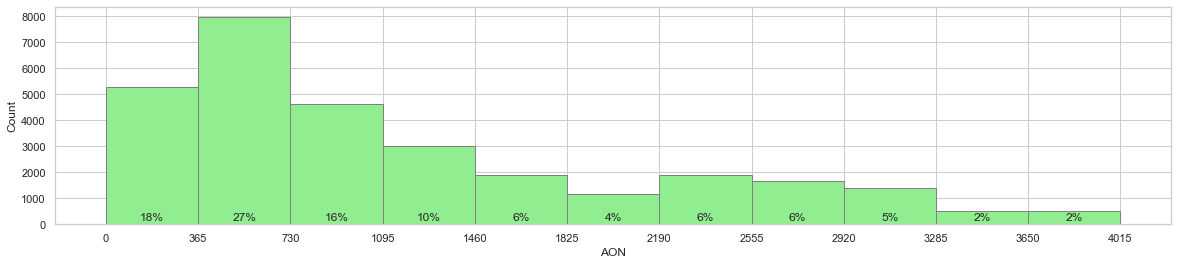

In [56]:
# Customers distribution of the age on network

print(churn.aon.describe())
plot_hist(churn,'aon',365)

***Analysis:***
    
- Minimun Age on network is 180 days.
- Average age on network for customers is 1200 days (3.2 years).
- A significant 27% of the users are in their 2nd year with the network.
- Almost 71% users have Age on network less than 4 years (<1460 days).
- 15% users are with the network from over 7 years (>2555 days).

#### 8.1.2 Numerical Variables Analysis

In [57]:
def plot_bychurn(data,col):
    # per month churn vs Non-Churn
    colList=list(data.filter(regex=(col)).columns)
    colList = colList[:2]
    churn.groupby("churn")[colList].median().plot.bar(figsize=[6,3])
    plt.title(str(col) +" wrt churn", loc='left', fontsize=12, fontweight=0, color='green')
    plt.tick_params(size=5,labelsize = 10) 
    plt.ylabel(col,fontsize=8)
    plt.xlabel("Churn type",fontsize= 8)
    plt.grid(0.3)
    plt.show()     
    plt.tight_layout()
    return churn.groupby('churn')[colList].median()

In [58]:
col_list.unique()

Index(['arpu', 'onnet_mou', 'offnet_mou', 'roam_ic_mou', 'roam_og_mou',
       'loc_og_t2t_mou', 'loc_og_t2m_mou', 'loc_og_t2f_mou', 'loc_og_t2c_mou',
       'loc_og_mou', 'std_og_t2t_mou', 'std_og_t2m_mou', 'std_og_t2f_mou',
       'std_og_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 'total_og_mou',
       'loc_ic_t2t_mou', 'loc_ic_t2m_mou', 'loc_ic_t2f_mou', 'loc_ic_mou',
       'std_ic_t2t_mou', 'std_ic_t2m_mou', 'std_ic_t2f_mou', 'std_ic_mou',
       'total_ic_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others',
       'total_rech_num', 'total_rech_amt', 'max_rech_amt', 'last_day_rch_amt',
       'max_rech_data', 'vol_mb', 'monthly_scheme', 'sachet_scheme',
       'total_rech_data_amt'],
      dtype='object')

***Analyse the columns/features wrt the difference between good phase and action phase.***

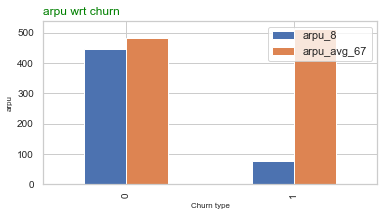

<Figure size 432x288 with 0 Axes>

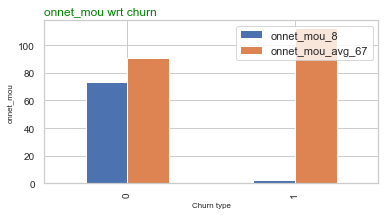

<Figure size 432x288 with 0 Axes>

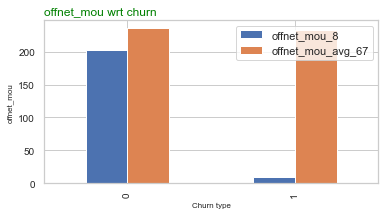

<Figure size 432x288 with 0 Axes>

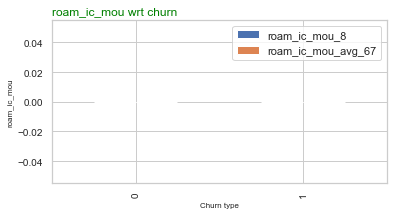

<Figure size 432x288 with 0 Axes>

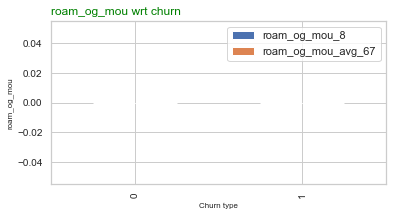

<Figure size 432x288 with 0 Axes>

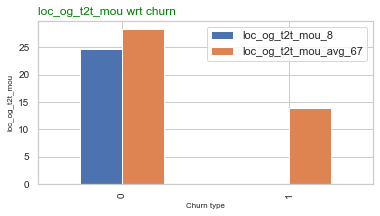

<Figure size 432x288 with 0 Axes>

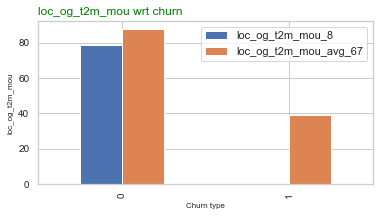

<Figure size 432x288 with 0 Axes>

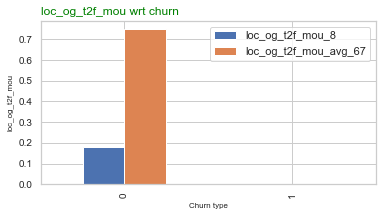

<Figure size 432x288 with 0 Axes>

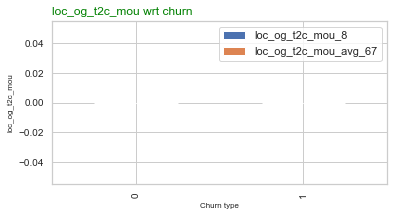

<Figure size 432x288 with 0 Axes>

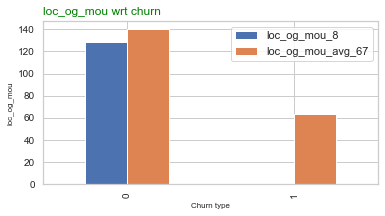

<Figure size 432x288 with 0 Axes>

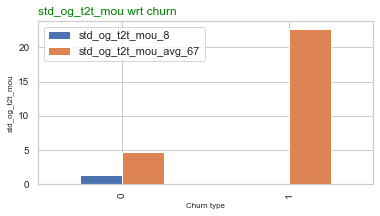

<Figure size 432x288 with 0 Axes>

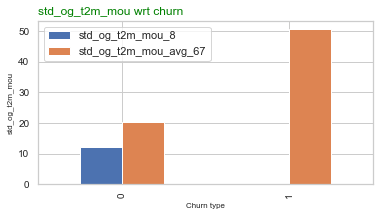

<Figure size 432x288 with 0 Axes>

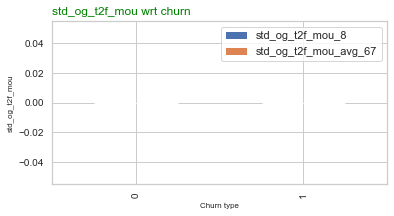

<Figure size 432x288 with 0 Axes>

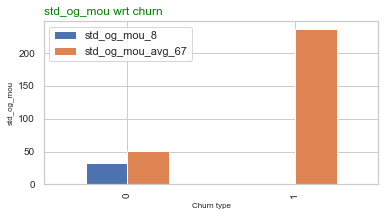

<Figure size 432x288 with 0 Axes>

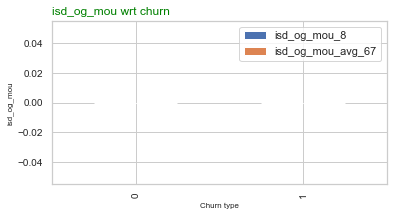

<Figure size 432x288 with 0 Axes>

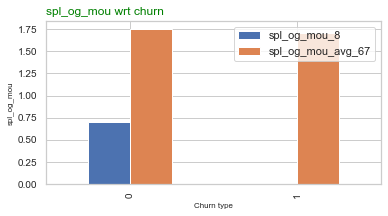

<Figure size 432x288 with 0 Axes>

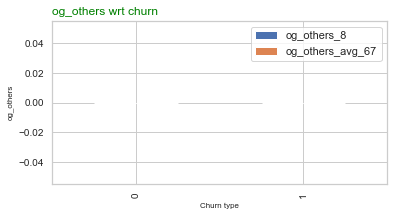

<Figure size 432x288 with 0 Axes>

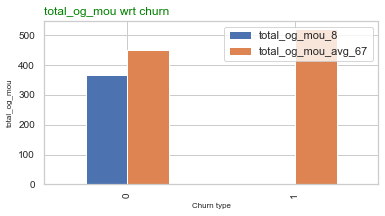

<Figure size 432x288 with 0 Axes>

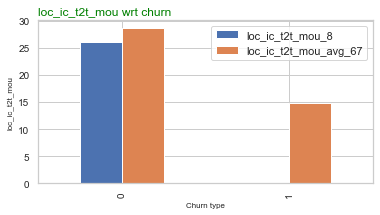

<Figure size 432x288 with 0 Axes>

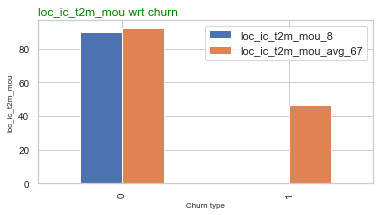

<Figure size 432x288 with 0 Axes>

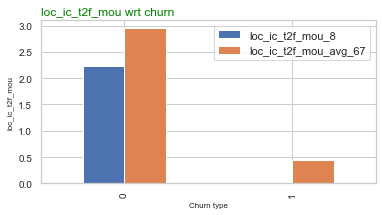

<Figure size 432x288 with 0 Axes>

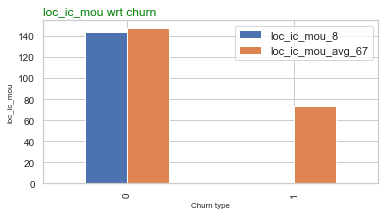

<Figure size 432x288 with 0 Axes>

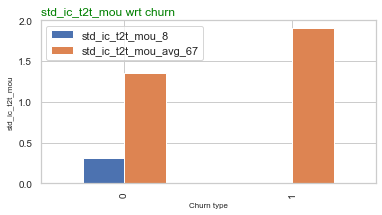

<Figure size 432x288 with 0 Axes>

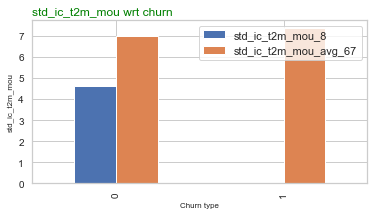

<Figure size 432x288 with 0 Axes>

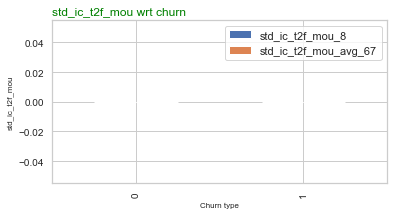

<Figure size 432x288 with 0 Axes>

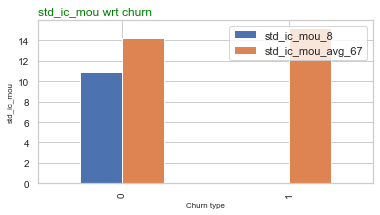

<Figure size 432x288 with 0 Axes>

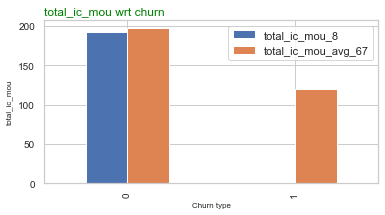

<Figure size 432x288 with 0 Axes>

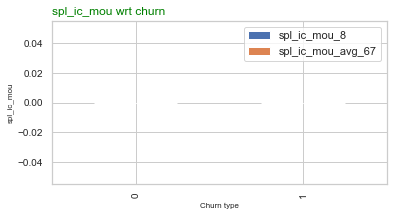

<Figure size 432x288 with 0 Axes>

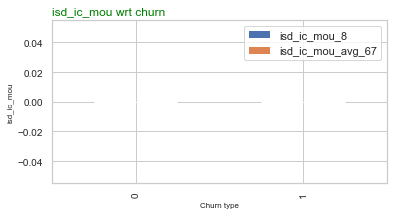

<Figure size 432x288 with 0 Axes>

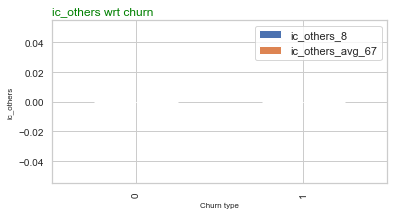

<Figure size 432x288 with 0 Axes>

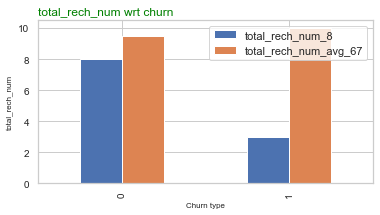

<Figure size 432x288 with 0 Axes>

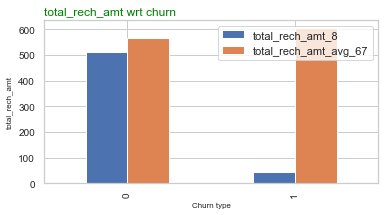

<Figure size 432x288 with 0 Axes>

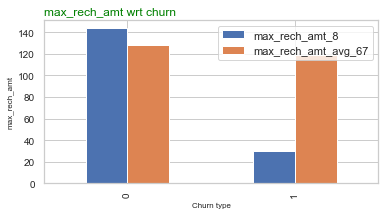

<Figure size 432x288 with 0 Axes>

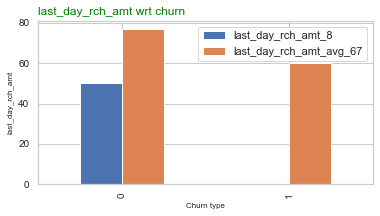

<Figure size 432x288 with 0 Axes>

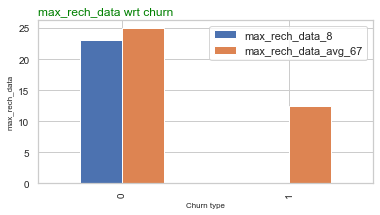

<Figure size 432x288 with 0 Axes>

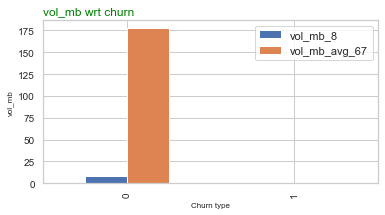

<Figure size 432x288 with 0 Axes>

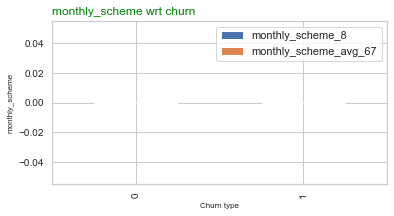

<Figure size 432x288 with 0 Axes>

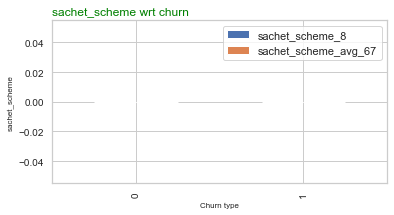

<Figure size 432x288 with 0 Axes>

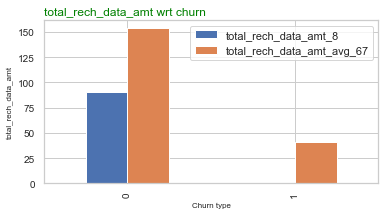

<Figure size 432x288 with 0 Axes>

In [59]:
for i in col_list.unique():
    plot_bychurn(churn, i)


***Analysis:-  if we focus on the churn = 1 for each variable then*** 
- If there is monthly decrease in Average revenue from the customers, there is a high chance of churn
- If the minutes of usage within the network is decrease from June to August, there is high chance of customer being churn.
- If the total recharge amount in August is very less, then there is high chance of customer being churn.
- If the total incoming minute in August is very very less, then there is high chance of customer being churn.
- If the total outgoing minute in August is very very less, then there is high chance of customer being churn.

***Also we observe from the above graphs that below variables do not contribute to the churn analysis:-***
- roam_ic_mou (roaming incoming minutes)
- roam_og_mou (roaming outgoing minutes)
- loc_og_t2c  
- std_og_t2f
- isd_og_mou
- og_others
- std_ic_t2f
- spl_ic_mou
- isd_ic_mou
- ic_others
- monthly_scheme
- sachet_scheme

In [60]:
drop_list = ['roam_ic_mou_avg_67','roam_ic_mou_8',
             'roam_og_mou_avg_67','roam_og_mou_8',
             'loc_og_t2c_mou_avg_67','loc_og_t2c_mou_8',
             'std_og_t2f_mou_avg_67','std_og_t2f_mou_8',
             'isd_og_mou_avg_67','isd_og_mou_8',
             'og_others_avg_67','og_others_8',
             'std_ic_t2f_mou_avg_67','std_ic_t2f_mou_8',
             'spl_ic_mou_avg_67','spl_ic_mou_8',
             'isd_ic_mou_avg_67','isd_ic_mou_8',
             'ic_others_avg_67','ic_others_8',
             'monthly_scheme_avg_67','monthly_scheme_8',
             'sachet_scheme_avg_67','sachet_scheme_8',
            ]

churn.drop(drop_list, axis = 1, inplace = True)

churn.shape

(29953, 65)

In [61]:
# update the numerical and categorical columns

num_col = churn.select_dtypes(exclude=('object','category')).head()
num_col = num_col.columns.tolist()

cat_col = churn.select_dtypes(include=('object','category')).head()
cat_col = cat_col.columns.tolist()

#### 8.1.3. Categorical Data Analysis 

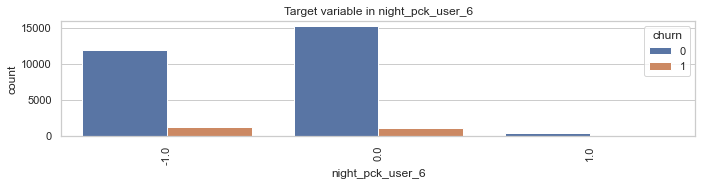

0.0     16333
-1.0    13213
1.0       407
Name: night_pck_user_6, dtype: int64


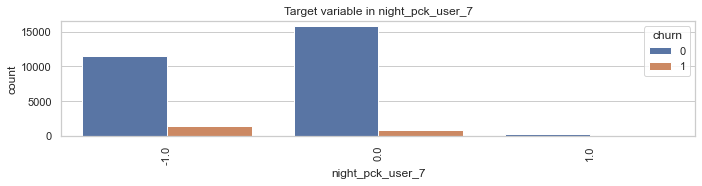

0.0     16663
-1.0    12915
1.0       375
Name: night_pck_user_7, dtype: int64


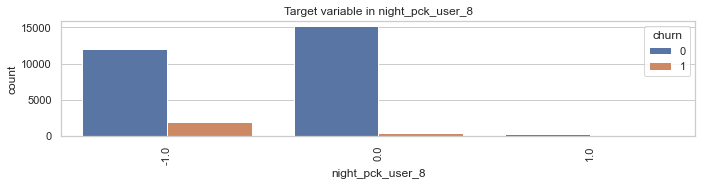

0.0     15594
-1.0    14018
1.0       341
Name: night_pck_user_8, dtype: int64


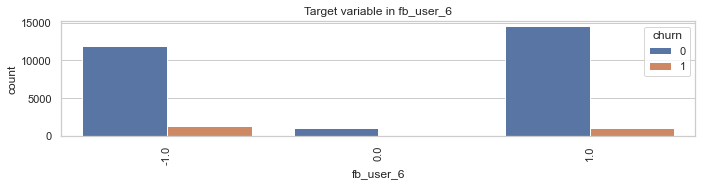

1.0     15511
-1.0    13213
0.0      1229
Name: fb_user_6, dtype: int64


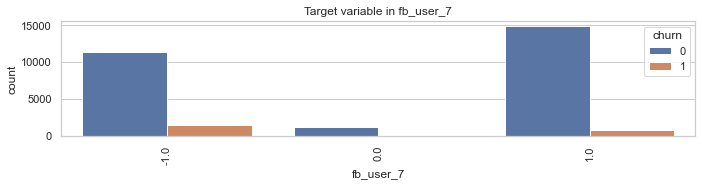

1.0     15705
-1.0    12915
0.0      1333
Name: fb_user_7, dtype: int64


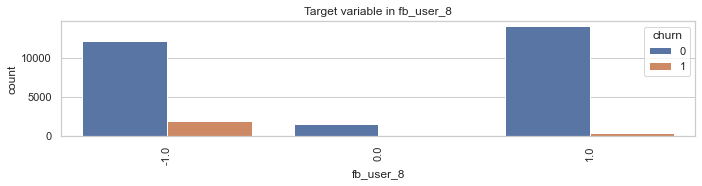

1.0     14297
-1.0    14018
0.0      1638
Name: fb_user_8, dtype: int64


<Figure size 432x288 with 0 Axes>

In [62]:
cat_col1 = cat_col
cat_col1.remove('churn')

count = 0

for i in cat_col1:
    
    plt.figure(figsize =(25,25))
    count = count + 1
    plt.subplot(10,2,count)
    sns.countplot(churn[i], hue=churn['churn'])
    plt.xticks(rotation = 90)
    plt.title('Target variable in'+' '+ i)
    plt.xlabel(i)
    plt.show()
    print(churn[i].value_counts())
    
plt.tight_layout()

***Analysis:--***
- It is observed that ***most of the high valued customers are NOT night pack users***, we cannot see any significant no of customers with night pack customer, hence we can drop these columns.
- However, on the other side, we can see a considerable amount of users having ***facebook pack or is having NULL values***. Hence, the analysis will be biased to one category, thus dropping the column.

In [63]:
churn.drop(['night_pck_user_6','night_pck_user_7','night_pck_user_8','fb_user_6', 'fb_user_7','fb_user_8'], axis = 1, inplace = True)

churn.shape

(29953, 59)

In [64]:
# update the numerical and categorical columns

num_col = churn.select_dtypes(exclude=('object','category')).head()
num_col = num_col.columns.tolist()

cat_col = churn.select_dtypes(include=('object','category')).head()
cat_col = cat_col.columns.tolist()

### 8.2 Correlation Matrix

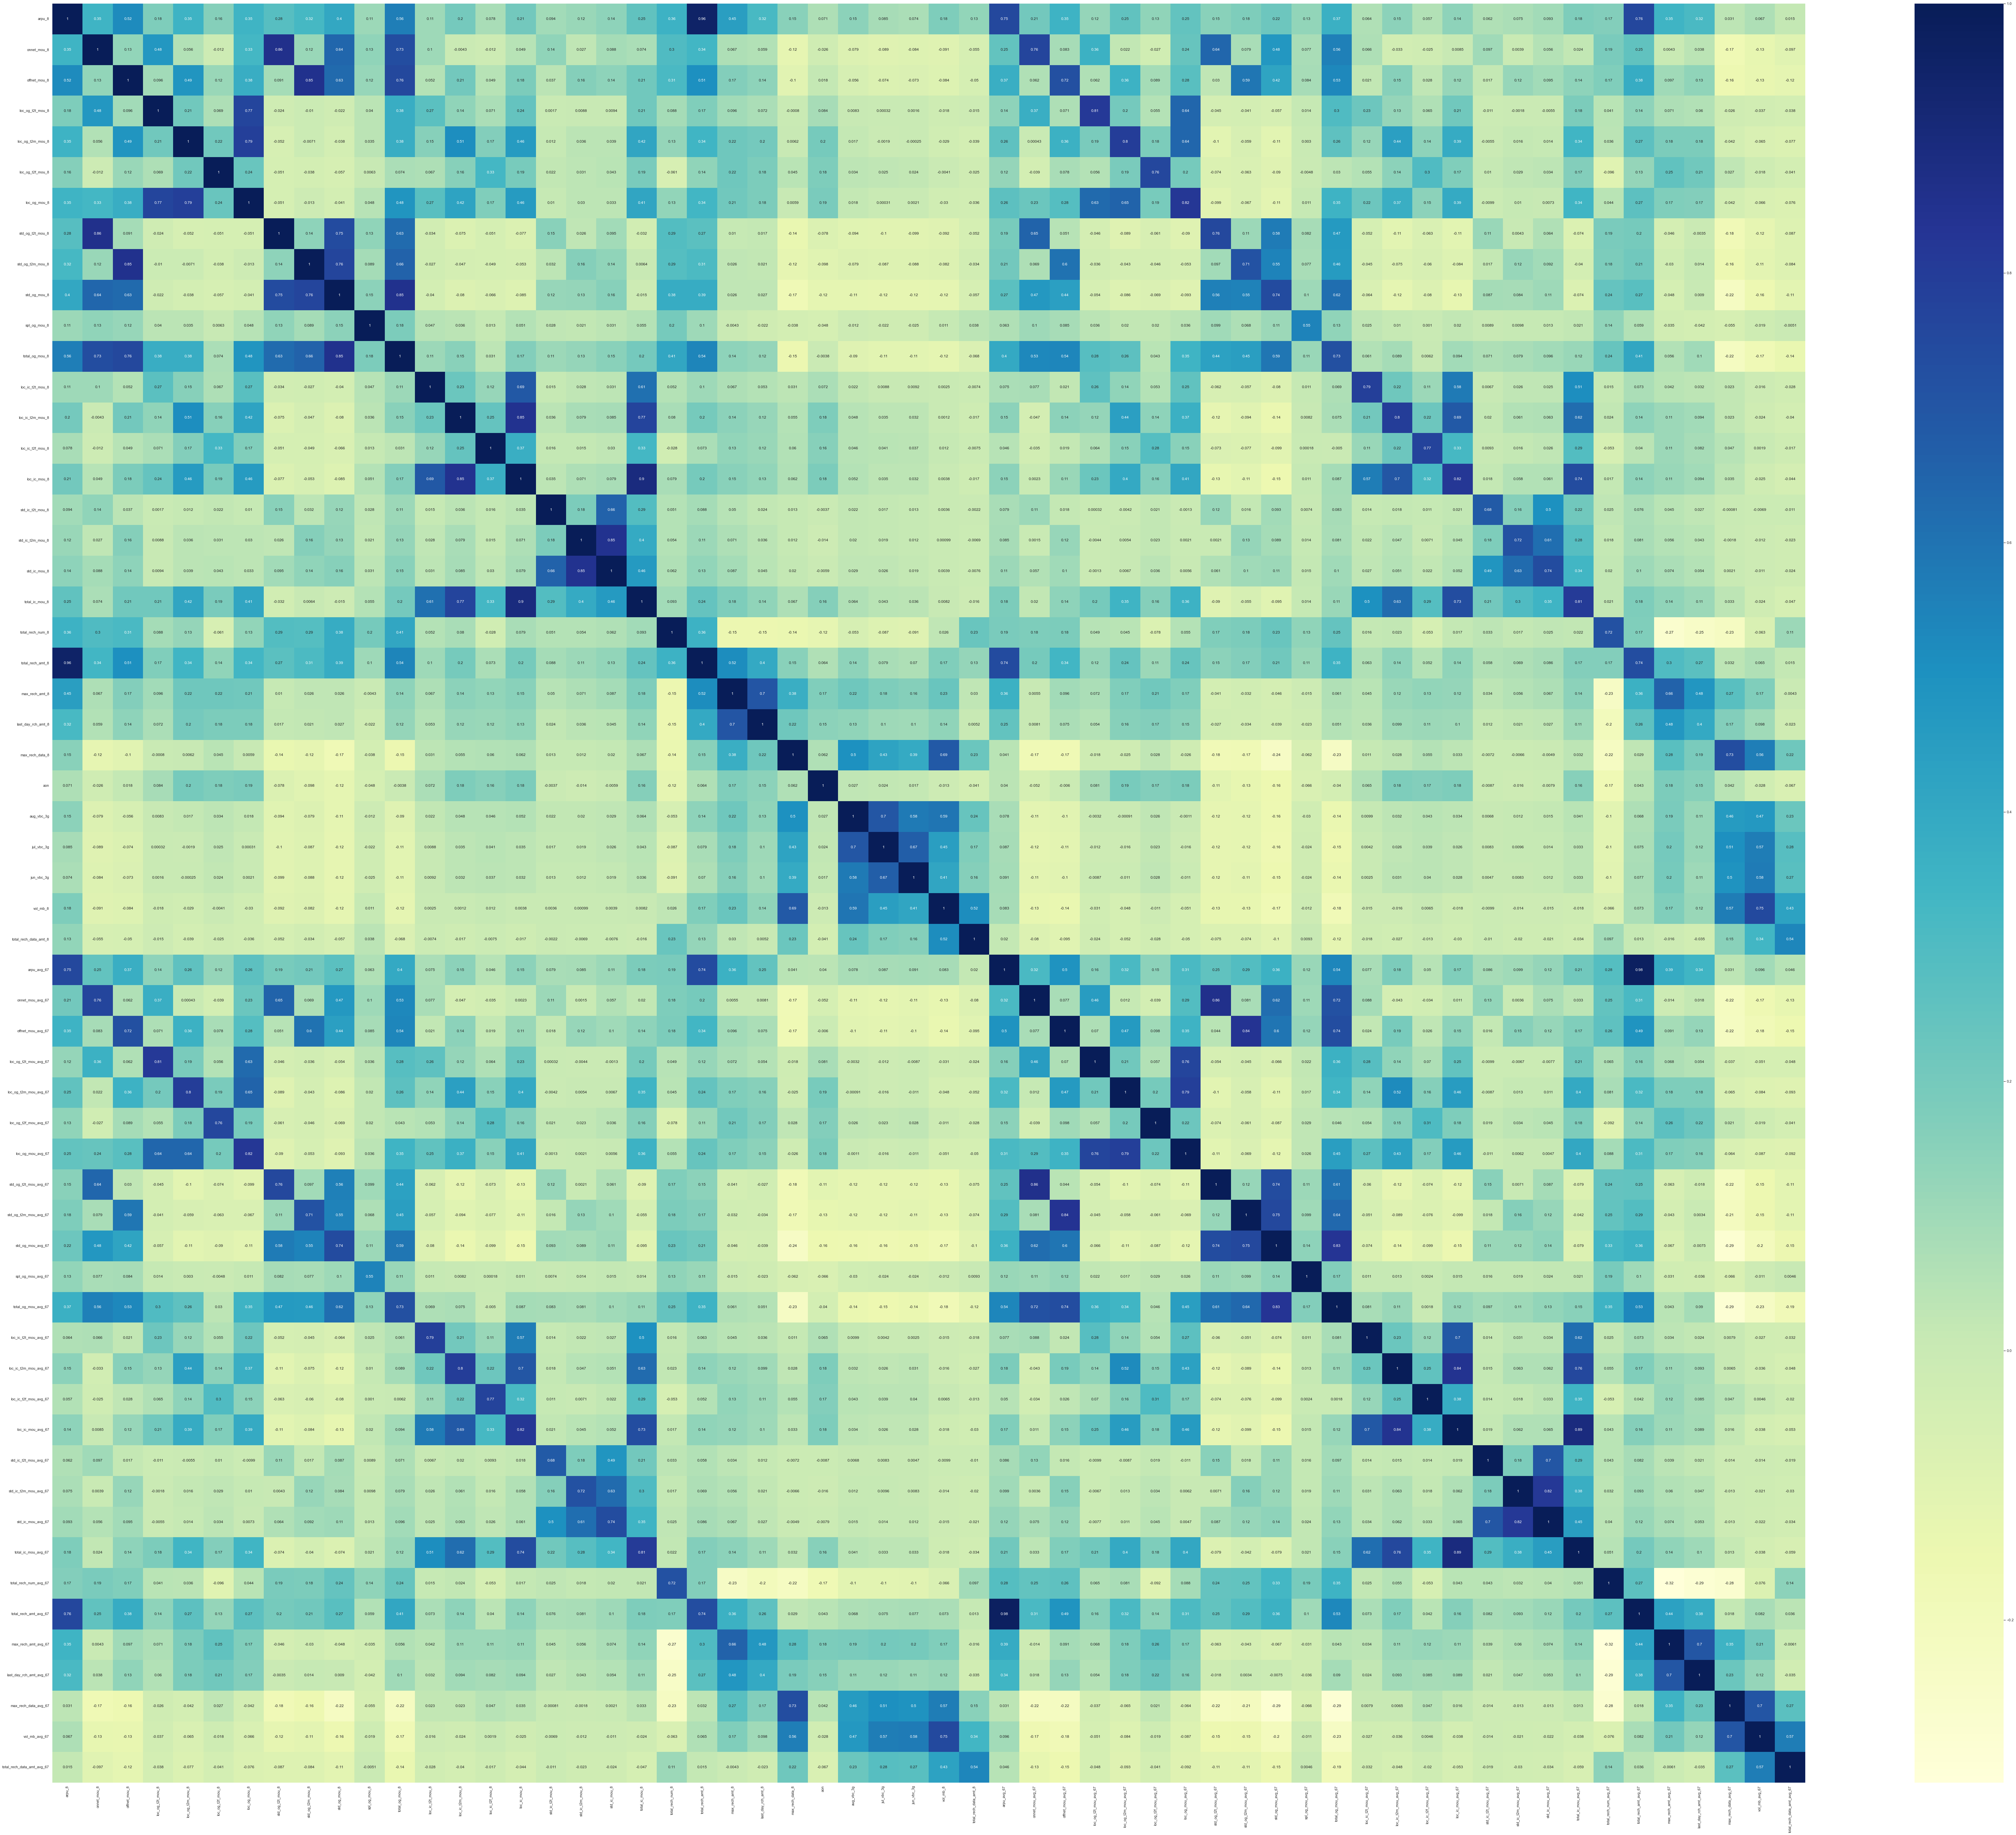

In [65]:
#finding the correlation matrix using heatmap
plt.figure(figsize=(120,100))

# heatmap
sns.heatmap(churn[num_col].corr(), cmap="YlGnBu", annot = True)
plt.show()

In [66]:
churn[num_col].corr()

arpu_8  onnet_mou_8  offnet_mou_8  \
arpu_8                      1.000000     0.347591      0.524531   
onnet_mou_8                 0.347591     1.000000      0.130686   
offnet_mou_8                0.524531     0.130686      1.000000   
loc_og_t2t_mou_8            0.178705     0.475087      0.096349   
loc_og_t2m_mou_8            0.352563     0.056305      0.487105   
loc_og_t2f_mou_8            0.160123    -0.011737      0.115206   
loc_og_mou_8                0.347131     0.332923      0.379678   
std_og_t2t_mou_8            0.279608     0.860648      0.090561   
std_og_t2m_mou_8            0.324453     0.115356      0.850904   
std_og_mou_8                0.401782     0.639341      0.631661   
spl_og_mou_8                0.108296     0.133322      0.122362   
total_og_mou_8              0.561724     0.731759      0.755008   
loc_ic_t2t_mou_8            0.106330     0.103939      0.051556   
loc_ic_t2m_mou_8            0.204994    -0.004266      0.209858   
loc_ic_t2f_mou_8            0.078074    -0.011879      0.049120   
loc_ic_mou_8                0.208655     0.048941      0.179740   
std_ic_t2t_mou_8            0.094258     0.135235      0.036506   
std_ic_t2m_mou_8            0.115111     0.026618      0.162348   
std_ic_mou_8                0.139564     0.088146      0.142009   
total_ic_mou_8              0.253483     0.073680      0.213540   
total_rech_num_8            0.357893     0.300435      0.314552   
total_rech_amt_8            0.955322     0.335209      0.507093   
max_rech_amt_8              0.447672     0.066568      0.166771   
last_day_rch_amt_8          0.320687     0.059261      0.141249   
max_rech_data_8             0.150956    -0.123788     -0.102294   
aon                         0.070668    -0.026012      0.018193   
aug_vbc_3g                  0.146493    -0.078504     -0.056182   
jul_vbc_3g                  0.085258    -0.089039     -0.074136   
jun_vbc_3g                  0.073729    -0.084428     -0.072996   
vol_mb_8                    0.177297    -0.090687     -0.084159   
total_rech_data_amt_8       0.130261    -0.054957     -0.050111   
arpu_avg_67                 0.752414     0.250728      0.373854   
onnet_mou_avg_67            0.206999     0.764479      0.061910   
offnet_mou_avg_67           0.352731     0.083168      0.724997   
loc_og_t2t_mou_avg_67       0.124075     0.363356      0.062008   
loc_og_t2m_mou_avg_67       0.252964     0.022046      0.359614   
loc_og_t2f_mou_avg_67       0.134496    -0.026911      0.089409   
loc_og_mou_avg_67           0.248839     0.238229      0.276806   
std_og_t2t_mou_avg_67       0.151539     0.643391      0.030044   
std_og_t2m_mou_avg_67       0.177105     0.078584      0.588278   
std_og_mou_avg_67           0.221193     0.478231      0.418285   
spl_og_mou_avg_67           0.129280     0.077231      0.083526   
total_og_mou_avg_67         0.367420     0.560009      0.533770   
loc_ic_t2t_mou_avg_67       0.063589     0.066349      0.021160   
loc_ic_t2m_mou_avg_67       0.148104    -0.032781      0.153991   
loc_ic_t2f_mou_avg_67       0.057145    -0.024628      0.028023   
loc_ic_mou_avg_67           0.143496     0.008474      0.121094   
std_ic_t2t_mou_avg_67       0.061763     0.097301      0.016513   
std_ic_t2m_mou_avg_67       0.074507     0.003943      0.118113   
std_ic_mou_avg_67           0.093125     0.055698      0.095044   
total_ic_mou_avg_67         0.176859     0.024185      0.141486   
total_rech_num_avg_67       0.168786     0.185940      0.174169   
total_rech_amt_avg_67       0.760301     0.254589      0.381596   
max_rech_amt_avg_67         0.345737     0.004315      0.097491   
last_day_rch_amt_avg_67     0.317433     0.037562      0.133333   
max_rech_data_avg_67        0.031273    -0.170964     -0.159574   
vol_mb_avg_67               0.067288    -0.126547     -0.132455   
total_rech_data_amt_avg_67  0.014921    -0.096800     -0.115458   

                            loc_og_t2t_mou_8  loc_og_t2m_mou_8  \
arpu_8    

***Analysis:- Drop the highly correlated variables***

- total_rech_amt_8 and arpu_8 => 0.955322
- total_rech_amt_avg_67 and arpu_avg_67	=> 0.976746

In [67]:
# Drop the average revenue variables for both good and action phase. 
# Drop the total recharge amounts for both good and action phase.

churn.drop(['total_rech_amt_8','arpu_8','total_rech_amt_avg_67','arpu_avg_67'], axis = 1, inplace = True)



In [68]:
# update the numerical and categorical columns

num_col = churn.select_dtypes(exclude=('object','category')).head()
num_col = num_col.columns.tolist()

cat_col = churn.select_dtypes(include=('object','category')).head()
cat_col = cat_col.columns.tolist()

In [69]:
churn.shape

(29953, 55)

### 8.3 Outliers

In [70]:
# Finding Outliers of each columns with the total number of rows as outliers
def get_outliers(df,x):
    q1, q3 = np.percentile(df[x], [25, 75])
    
    iqr = q3-q1 
    min_val = q1 - 1.5*iqr
    max_val = q3 + 1.5*iqr

    # Anything below the minimum or above the maximum becomes outlier
    outliers = df[(df[x] < min_val) | (df[x] > max_val)]
    return outliers, x, len(outliers)

outliers_col = {}
for i in num_col:
    outlier, x, l = get_outliers(churn,i)
    if l > 0:
        outliers_col[x]=l

outliers_col_list = sorted(outliers_col.keys(), key=lambda outliers_col: outliers_col[1])
outliers_col_list

['max_rech_amt_8',
 'last_day_rch_amt_8',
 'max_rech_data_8',
 'max_rech_amt_avg_67',
 'last_day_rch_amt_avg_67',
 'max_rech_data_avg_67',
 'offnet_mou_8',
 'offnet_mou_avg_67',
 'onnet_mou_8',
 'onnet_mou_avg_67',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_8',
 'loc_og_mou_8',
 'total_og_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_8',
 'total_ic_mou_8',
 'total_rech_num_8',
 'aon',
 'vol_mb_8',
 'total_rech_data_amt_8',
 'loc_og_t2t_mou_avg_67',
 'loc_og_t2m_mou_avg_67',
 'loc_og_t2f_mou_avg_67',
 'loc_og_mou_avg_67',
 'total_og_mou_avg_67',
 'loc_ic_t2t_mou_avg_67',
 'loc_ic_t2m_mou_avg_67',
 'loc_ic_t2f_mou_avg_67',
 'loc_ic_mou_avg_67',
 'total_ic_mou_avg_67',
 'total_rech_num_avg_67',
 'vol_mb_avg_67',
 'total_rech_data_amt_avg_67',
 'spl_og_mou_8',
 'spl_og_mou_avg_67',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'std_og_mou_8',
 'std_ic_t2t_mou_8',
 'std_ic_t2m_mou_8',
 'std_ic_mou_8',
 'std_og_t2t_mou_avg_67',
 'std_og_t2m_

In [71]:
# Check the outliers before capping
churn[outliers_col_list].describe().T

count         mean          std    min      25%  \
max_rech_amt_8              29953.0   160.224351   173.298179    0.0   50.000   
last_day_rch_amt_8          29953.0    92.443061   145.247315    0.0    0.000   
max_rech_data_8             29953.0    72.540013   110.612367    0.0    0.000   
max_rech_amt_avg_67         29953.0   170.814810   154.288193    0.0  102.000   
last_day_rch_amt_avg_67     29953.0   100.655878   115.992005    0.0   30.000   
max_rech_data_avg_67        29953.0    79.010717   103.245264    0.0    0.000   
offnet_mou_8                29953.0   335.123008   481.985106    0.0   46.760   
offnet_mou_avg_67           29953.0   376.016754   457.874180    0.0   83.165   
onnet_mou_8                 29953.0   234.345252   458.751242    0.0   10.440   
onnet_mou_avg_67            29953.0   264.476312   439.846658    0.0   20.620   
loc_og_t2t_mou_8            29953.0    78.153334   227.540167    0.0    2.540   
loc_og_t2m_mou_8            29953.0   151.810056   233.745412    0.0   13.130   
loc_og_t2f_mou_8            29953.0     5.891865    19.516259    0.0    0.000   
loc_og_mou_8                29953.0   235.863120   363.548405    0.0   22.540   
total_og_mou_8              29953.0   551.929765   700.585424    0.0   72.490   
loc_ic_t2t_mou_8            29953.0    62.662397   159.026025    0.0    4.880   
loc_ic_t2m_mou_8            29953.0   146.303887   214.996335    0.0   24.230   
loc_ic_t2f_mou_8            29953.0    14.414880    43.335424    0.0    0.000   
loc_ic_mou_8                29953.0   223.390506   308.483647    0.0   40.540   
total_ic_mou_8              29953.0   280.074127   361.356861    0.0   61.490   
total_rech_num_8            29953.0     9.975595     9.276133    0.0    4.000   
aon                         29953.0  1209.280573   957.449442  180.0  460.000   
vol_mb_8                    29953.0   457.703777   968.146184    0.0    0.000   
total_rech_data_amt_8       29953.0   463.640890  1623.839242    0.0    0.000   
loc_og_t2t_mou_avg_67       29953.0    85.168479   222.442596    0.0    6.475   
loc_og_t2m_mou_avg_67       29953.0   163.198576   232.307400    0.0   24.695   
loc_og_t2f_mou_avg_67       29953.0     6.387420    20.969830    0.0    0.000   
loc_og_mou_avg_67           29953.0   254.762766   358.408928    0.0   40.170   
total_og_mou_avg_67         29953.0   619.391057   651.968007    0.0  142.600   
loc_ic_t2t_mou_avg_67       29953.0    66.097918   157.266020    0.0    8.545   
loc_ic_t2m_mou_avg_67       29953.0   151.093198   207.117758    0.0   34.095   
loc_ic_t2f_mou_avg_67       29953.0    15.669084    44.381007    0.0    0.180   
loc_ic_mou_avg_67           29953.0   232.869870   301.138115    0.0   56.260   
total_ic_mou_avg_67         29953.0   293.532905   351.166085    0.0   84.935   
total_rech_num_avg_67       29953.0    11.789220     8.635731    0.5    6.500   
vol_mb_avg_67               29953.0   483.422527   887.871612    0.0    0.000   
total_rech_data_amt_avg_67  29953.0   492.672953  1239.408758    0.0    0.000   
spl_og_mou_8                29953.0     6.549024    20.289977    0.0    0.000   
spl_og_mou_avg_67           29953.0     6.465896    17.314013    0.0    0.000   
std_og_t2t_mou_8            29953.0   148.587258   397.838396    0.0    0.000   
std_og_t2m_mou_8            29953.0   157.322964   409.035684    0.0    0.000   
std_og_mou_8                29953.0   307.500304   609.109928    0.0    0.000   
std_ic_t2t_mou_8            29953.0    13.919836    71.387685    0.0    0.000   
std_ic_t2m_mou_8            29953.0    27.920360   103.374423    0.0    0.000   
std_ic_mou_8                29953.0    44.408522   138.876998    0.0    0.410   
std_og_t2t_mou_avg_67       29953.0   170.138053   385.840944    0.0    0.000   
std_og_t2m_mou_avg_67       29953.0   183.700545   394.079094    0.0    0.500   
std_og_mou_avg_67           29953.0   355.659646   583.378556    0.0    1.840   
std_ic_t2t_mou_avg_67       29953.0    15.164835    75.110128

In [72]:
outliers_col_list_with_number = sorted(outliers_col.items(), key=lambda outliers_col: outliers_col[1])
outliers_col_list_with_number

[('aon', 51),
 ('max_rech_data_avg_67', 372),
 ('max_rech_data_8', 482),
 ('last_day_rch_amt_8', 1078),
 ('total_og_mou_avg_67', 1100),
 ('last_day_rch_amt_avg_67', 1448),
 ('max_rech_amt_8', 1515),
 ('total_og_mou_8', 1552),
 ('total_rech_num_8', 1658),
 ('total_rech_num_avg_67', 1701),
 ('offnet_mou_avg_67', 1783),
 ('vol_mb_avg_67', 1839),
 ('total_ic_mou_8', 1949),
 ('total_ic_mou_avg_67', 1949),
 ('offnet_mou_8', 1961),
 ('std_og_mou_avg_67', 1982),
 ('loc_og_mou_avg_67', 2011),
 ('loc_ic_mou_avg_67', 2027),
 ('loc_ic_mou_8', 2040),
 ('loc_og_mou_8', 2069),
 ('loc_ic_t2m_mou_8', 2091),
 ('loc_ic_t2m_mou_avg_67', 2120),
 ('loc_og_t2m_mou_avg_67', 2158),
 ('loc_og_t2m_mou_8', 2217),
 ('vol_mb_8', 2299),
 ('max_rech_amt_avg_67', 2450),
 ('loc_ic_t2t_mou_8', 2617),
 ('loc_ic_t2t_mou_avg_67', 2677),
 ('spl_og_mou_avg_67', 2760),
 ('total_rech_data_amt_avg_67', 2919),
 ('loc_og_t2t_mou_avg_67', 2977),
 ('std_ic_mou_avg_67', 2999),
 ('loc_og_t2t_mou_8', 3061),
 ('std_ic_t2m_mou_avg_67', 

In [73]:
# Checking the value count of the coulumns having outliers        
for i in outliers_col_list:
    if len(churn[i].value_counts()) > 1:
        print(i,' : ',len(churn[i].value_counts()))

max_rech_amt_8  :  182
last_day_rch_amt_8  :  181
max_rech_data_8  :  49
max_rech_amt_avg_67  :  914
last_day_rch_amt_avg_67  :  735
max_rech_data_avg_67  :  333
offnet_mou_8  :  20140
offnet_mou_avg_67  :  26672
onnet_mou_8  :  15854
onnet_mou_avg_67  :  23538
loc_og_t2t_mou_8  :  10056
loc_og_t2m_mou_8  :  15118
loc_og_t2f_mou_8  :  2988
loc_og_mou_8  :  17565
total_og_mou_8  :  22287
loc_ic_t2t_mou_8  :  9359
loc_ic_t2m_mou_8  :  15110
loc_ic_t2f_mou_8  :  4652
loc_ic_mou_8  :  18048
total_ic_mou_8  :  19565
total_rech_num_8  :  96
aon  :  3294
vol_mb_8  :  13948
total_rech_data_amt_8  :  1619
loc_og_t2t_mou_avg_67  :  18191
loc_og_t2m_mou_avg_67  :  23301
loc_og_t2f_mou_avg_67  :  6251
loc_og_mou_avg_67  :  24951
total_og_mou_avg_67  :  27509
loc_ic_t2t_mou_avg_67  :  18013
loc_ic_t2m_mou_avg_67  :  23802
loc_ic_t2f_mou_avg_67  :  9347
loc_ic_mou_avg_67  :  25557
total_ic_mou_avg_67  :  26245
total_rech_num_avg_67  :  169
vol_mb_avg_67  :  17618
total_rech_data_amt_avg_67  :  3865


In [74]:
def get_boundaries(df,var):
    q1, q3 = np.percentile(df[var], [25, 75])
    iqr = q3-q1 
    min_val = q1 - 1.5*iqr
    max_val = q3 + 1.5*iqr
    return min_val, max_val
    
for col in num_col:
    lower_val, upper_val = get_boundaries(churn, col)
    churn[col] = np.where((churn[col] < lower_val), lower_val, 
                          np.where((churn[col] > upper_val), upper_val, churn[col]))


In [75]:
outliers_col = {}
for i in num_col:
    outlier, x, l = get_outliers(churn,i)
    if l > 0:
        outliers_col[x]=l

outliers_col_list_with_number = sorted(outliers_col.items(), key=lambda outliers_col: outliers_col[1])
print('columns with outliers =', len(outliers_col_list_with_number))

columns with outliers = 0


In [76]:
# Check the outliers after capping
churn[outliers_col_list].describe().T

count         mean         std    min      25%  \
max_rech_amt_8              29953.0   146.125797  104.885213    0.0   50.000   
last_day_rch_amt_8          29953.0    82.484960   88.650568    0.0    0.000   
max_rech_data_8             29953.0    69.583848   95.871491    0.0    0.000   
max_rech_amt_avg_67         29953.0   153.291824   87.538658    0.0  102.000   
last_day_rch_amt_avg_67     29953.0    90.769021   71.458210    0.0   30.000   
max_rech_data_avg_67        29953.0    76.563015   90.397161    0.0    0.000   
offnet_mou_8                29953.0   292.456711  307.148124    0.0   46.760   
offnet_mou_avg_67           29953.0   340.647961  325.059601    0.0   83.165   
onnet_mou_8                 29953.0   160.962175  199.326657    0.0   10.440   
onnet_mou_avg_67            29953.0   206.899934  246.844453    0.0   20.620   
loc_og_t2t_mou_8            29953.0    47.850319   58.567828    0.0    2.540   
loc_og_t2m_mou_8            29953.0   128.945151  147.041682    0.0   13.130   
loc_og_t2f_mou_8            29953.0     2.447952    3.659709    0.0    0.000   
loc_og_mou_8                29953.0   202.647885  227.658405    0.0   22.540   
total_og_mou_8              29953.0   507.590489  528.044542    0.0   72.490   
loc_ic_t2t_mou_8            29953.0    43.305742   49.338407    0.0    4.880   
loc_ic_t2m_mou_8            29953.0   125.294044  128.284393    0.0   24.230   
loc_ic_t2f_mou_8            29953.0     7.214720    9.969898    0.0    0.000   
loc_ic_mou_8                29953.0   194.606101  194.832530    0.0   40.540   
total_ic_mou_8              29953.0   248.141744  237.608057    0.0   61.490   
total_rech_num_8            29953.0     9.355257    7.012414    0.0    4.000   
aon                         29953.0  1208.706741  955.827187  180.0  460.000   
vol_mb_8                    29953.0   356.482838  511.679892    0.0    0.000   
total_rech_data_amt_8       29953.0   209.222268  285.166818    0.0    0.000   
loc_og_t2t_mou_avg_67       29953.0    53.524936   61.410666    0.0    6.475   
loc_og_t2m_mou_avg_67       29953.0   141.238182  150.018757    0.0   24.695   
loc_og_t2f_mou_avg_67       29953.0     3.037855    4.249405    0.0    0.000   
loc_og_mou_avg_67           29953.0   222.611075  233.197656    0.0   40.170   
total_og_mou_avg_67         29953.0   590.111076  539.437565    0.0  142.600   
loc_ic_t2t_mou_avg_67       29953.0    46.844766   49.581876    0.0    8.545   
loc_ic_t2m_mou_avg_67       29953.0   130.781120  124.665351    0.0   34.095   
loc_ic_t2f_mou_avg_67       29953.0     8.426627   11.123434    0.0    0.180   
loc_ic_mou_avg_67           29953.0   205.538936  192.525266    0.0   56.260   
total_ic_mou_avg_67         29953.0   262.892606  231.668983    0.0   84.935   
total_rech_num_avg_67       29953.0    11.181635    6.465049    0.5    6.500   
vol_mb_avg_67               29953.0   407.226950  523.113557    0.0    0.000   
total_rech_data_amt_avg_67  29953.0   329.299795  412.731012    0.0    0.000   
spl_og_mou_8                29953.0     3.792351    5.441338    0.0    0.000   
spl_og_mou_avg_67           29953.0     4.485439    5.781821    0.0    0.000   
std_og_t2t_mou_8            29953.0    49.215778   76.118246    0.0    0.000   
std_og_t2m_mou_8            29953.0    75.125803  109.146829    0.0    0.000   
std_og_mou_8                29953.0   219.856944  319.721643    0.0    0.000   
std_ic_t2t_mou_8            29953.0     4.407233    6.590962    0.0    0.000   
std_ic_t2m_mou_8            29953.0    14.007787   19.039672    0.0    0.000   
std_ic_mou_8                29953.0    24.988783   32.122053    0.0    0.410   
std_og_t2t_mou_avg_67       29953.0    83.569790  125.736051    0.0    0.000   
std_og_t2m_mou_avg_67       29953.0   111.654010  156.213954    0.0    0.500   
std_og_mou_avg_67           29953.0   311.566482  428.949685    0.0    1.840   
std_ic_t2t_mou_avg_67       29953.0     6.327496    8.799561    0.0    0.000   
std_ic_t2m_mou_avg_67       29

# 9. Train-Test Data Split

In [77]:
# Import library
from sklearn.model_selection import train_test_split

# Putting feature variables into X
X = churn.drop(['churn'], axis=1)
# Putting target variable to y
y = churn['churn']

In [78]:
# Splitting data into train and test set 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

In [79]:
# print shapes of train and test sets
X_train.shape

(23962, 54)

In [80]:
y_train.shape

(23962,)

In [81]:
X_test.shape

(5991, 54)

In [82]:
y_test.shape

(5991,)

In [83]:
X_train_bck = X_train.copy()
X_test_bck = X_test.copy()
y_train_bck = y_train.copy()
y_test_bck = y_test.copy()

## 10. Performance Scaling

In [84]:
X_train.head()


onnet_mou_8  offnet_mou_8  loc_og_t2t_mou_8  loc_og_t2m_mou_8  \
56958         0.00        197.01              0.00             87.83   
45202        39.16       1027.01              0.00              0.00   
45991        54.88        423.91             34.86            375.96   
24597       136.41         68.18             25.26             61.56   
33873         0.00          0.00              0.00              0.00   

       loc_og_t2f_mou_8  loc_og_mou_8  std_og_t2t_mou_8  std_og_t2m_mou_8  \
56958              0.00         87.83              0.00            109.18   
45202              0.00          0.00              0.00              0.00   
45991              2.58        413.41             17.79              7.60   
24597              0.00         86.83            101.43              2.26   
33873              0.00          0.00              0.00              0.00   

       std_og_mou_8  spl_og_mou_8  total_og_mou_8  loc_ic_t2t_mou_8  \
56958        109.18          0.00          197.01              0.00   
45202          0.00          0.00            0.00              0.00   
45991         33.89          9.73          457.04             29.06   
24597        103.69          1.76          192.29             19.36   
33873          0.00          0.00            0.00              1.55   

       loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  loc_ic_mou_8  std_ic_t2t_mou_8  \
56958             31.44              0.00         31.44              0.70   
45202              0.00              0.00          0.00              0.00   
45991            195.99             19.33        244.39              0.00   
24597            222.08             12.33        253.78              6.88   
33873              0.98              0.00          2.53              0.00   

       std_ic_t2m_mou_8  std_ic_mou_8  total_ic_mou_8  total_rech_num_8  \
56958              1.03          1.73           42.18              17.0   
45202              0.00          0.00            0.00              26.0   
45991              0.00          0.66          245.44               4.0   
24597              0.23          7.11          261.48              26.5   
33873              0.00          0.00            7.74               3.0   

       max_rech_amt_8  last_day_rch_amt_8  max_rech_data_8     aon  \
56958           420.0               325.0            385.0   479.0   
45202           130.0               130.0              0.0  3560.0   
45991           250.0                26.0              0.0   340.0   
24597            30.0                30.0             25.0  2922.0   
33873           252.0                 0.0            252.0   334.0   

       aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  vol_mb_8  total_rech_data_amt_8  \
56958     322.825      344.65     246.875  1544.325                  770.0   
45202       0.000        0.00       0.000     0.000                    0.0   
45991       0.000        0.00       0.000     0.000                    0.0   
24597       0.000        0.00       0.000    48.600                  400.0   
33873     322.825      344.65      16.080  1113.690                  252.0   

       onnet_mou_avg_67  offnet_mou_avg_67  loc_og_t2t_mou_avg_67  \
56958             0.000           145.7150                  0.000   
45202            39.895          1120.2275                  0.000   
45991            49.125           322.1350                 36.025   
24597           214.240            55.4000                 23.185   
33873             0.000             5.3750                  0.000   

       loc_og_t2m_mou_avg_67  loc_og_t2f_mou_avg_67  loc_og_mou_avg_67  \
56958                 71.575                  0.000             71.575   
45202                  0.000                  0.000              0.000   
45991                281.185                  9.765            326.995   
24597                 41.645                  0.000             64.835   
33873                  0.000                  0.000              0.000   

       std_og_t2t_mo

In [85]:
# apply scaling on the dataset
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train[num_col] = scaler.fit_transform(X_train[num_col])

In [86]:
X_train.head()


onnet_mou_8  offnet_mou_8  loc_og_t2t_mou_8  loc_og_t2m_mou_8  \
56958     0.000000      0.191829          0.000000          0.185734   
45202     0.066836      1.000000          0.000000          0.000000   
45991     0.093665      0.412761          0.197490          0.795043   
24597     0.232815      0.066387          0.143104          0.130181   
33873     0.000000      0.000000          0.000000          0.000000   

       loc_og_t2f_mou_8  loc_og_mou_8  std_og_t2t_mou_8  std_og_t2m_mou_8  \
56958          0.000000      0.118227          0.000000          0.371014   
45202          0.000000      0.000000          0.000000          0.000000   
45991          0.262595      0.556489          0.091009          0.025826   
24597          0.000000      0.116881          0.518890          0.007680   
33873          0.000000      0.000000          0.000000          0.000000   

       std_og_mou_8  spl_og_mou_8  total_og_mou_8  loc_ic_t2t_mou_8  \
56958      0.122248      0.000000        0.107673          0.000000   
45202      0.000000      0.000000        0.000000          0.000000   
45991      0.037946      0.633876        0.249788          0.186935   
24597      0.116101      0.114658        0.105093          0.124538   
33873      0.000000      0.000000        0.000000          0.009971   

       loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  loc_ic_mou_8  std_ic_t2t_mou_8  \
56958          0.073418          0.000000      0.048155          0.039660   
45202          0.000000          0.000000      0.000000          0.000000   
45991          0.457675          0.692832      0.374320          0.000000   
24597          0.518600          0.441935      0.388703          0.389802   
33873          0.002288          0.000000      0.003875          0.000000   

       std_ic_t2m_mou_8  std_ic_mou_8  total_ic_mou_8  total_rech_num_8  \
56958          0.018873      0.018147        0.051899          0.641509   
45202          0.000000      0.000000        0.000000          0.981132   
45991          0.000000      0.006923        0.301991          0.150943   
24597          0.004214      0.074579        0.321727          1.000000   
33873          0.000000      0.000000        0.009523          0.113208   

       max_rech_amt_8  last_day_rch_amt_8  max_rech_data_8       aon  \
56958        1.000000            1.000000         1.000000  0.084943   
45202        0.309524            0.400000         0.000000  0.960227   
45991        0.595238            0.080000         0.000000  0.045455   
24597        0.071429            0.092308         0.064935  0.778977   
33873        0.600000            0.000000         0.654545  0.043750   

       aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  vol_mb_8  total_rech_data_amt_8  \
56958         1.0         1.0    1.000000   1.00000               1.000000   
45202         0.0         0.0    0.000000   0.00000               0.000000   
45991         0.0         0.0    0.000000   0.00000               0.000000   
24597         0.0         0.0    0.000000   0.03147               0.519481   
33873         1.0         1.0    0.065134   0.72115               0.327273   

       onnet_mou_avg_67  offnet_mou_avg_67  loc_og_t2t_mou_avg_67  \
56958          0.000000           0.130076               0.000000   
45202          0.054063           1.000000               0.000000   
45991          0.066571           0.287562               0.190735   
24597          0.290325           0.049454               0.122753   
33873          0.000000           0.004798               0.000000   

       loc_og_t2m_mou_avg_67  loc_og_t2f_mou_avg_67  loc_og_mou_avg_67  \
56958               0.145642               0.000000           0.092115   
45202               0.000000               0.000000           0.000000   
45991               0.572160               0.827542           0.420832   
24597               0.084740               0.000000           0.083441   
33873               0.000000               0.000000           0.000000   

       s

# 11. Class Imbalance using SMOTE

In [87]:
#!pip install imblearn

In [88]:
#!pip install Tensorflow

In [89]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_sm,y_train_sm = sm.fit_resample(X_train,y_train)

In [90]:
#Dimension of X_train_sm 
X_train_sm

onnet_mou_8  offnet_mou_8  loc_og_t2t_mou_8  loc_og_t2m_mou_8  \
0         0.000000      0.191829          0.000000          0.185734   
1         0.066836      1.000000          0.000000          0.000000   
2         0.093665      0.412761          0.197490          0.795043   
3         0.232815      0.066387          0.143104          0.130181   
4         0.000000      0.000000          0.000000          0.000000   
...            ...           ...               ...               ...   
43987     0.000000      0.000000          0.000000          0.000000   
43988     0.002878      0.004288          0.009552          0.009313   
43989     0.001754      0.027597          0.005821          0.011322   
43990     0.000000      0.000000          0.000000          0.000000   
43991     0.000412      0.000133          0.000000          0.000000   

       loc_og_t2f_mou_8  loc_og_mou_8  std_og_t2t_mou_8  std_og_t2m_mou_8  \
0              0.000000      0.118227          0.000000          0.371014   
1              0.000000      0.000000          0.000000          0.000000   
2              0.262595      0.556489          0.091009          0.025826   
3              0.000000      0.116881          0.518890          0.007680   
4              0.000000      0.000000          0.000000          0.000000   
...                 ...           ...               ...               ...   
43987          0.000000      0.000000          0.000000          0.000000   
43988          0.000000      0.008198          0.000000          0.000000   
43989          0.000000      0.008593          0.000000          0.075835   
43990          0.000000      0.000000          0.000000          0.000000   
43991          0.000000      0.000000          0.000000          0.000000   

       std_og_mou_8  spl_og_mou_8  total_og_mou_8  loc_ic_t2t_mou_8  \
0          0.122248      0.000000        0.107673          0.000000   
1          0.000000      0.000000        0.000000          0.000000   
2          0.037946      0.633876        0.249788          0.186935   
3          0.116101      0.114658        0.105093          0.124538   
4          0.000000      0.000000        0.000000          0.009971   
...             ...           ...             ...               ...   
43987      0.000000      0.000000        0.000000          0.000000   
43988      0.000000      0.000000        0.003328          0.016404   
43989      0.024987      0.000000        0.015687          0.011101   
43990      0.000000      0.000000        0.000000          0.000000   
43991      0.000000      0.000000        0.000000          0.000000   

       loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  loc_ic_mou_8  std_ic_t2t_mou_8  \
0              0.073418          0.000000      0.048155          0.039660   
1              0.000000          0.000000      0.000000          0.000000   
2              0.457675          0.692832      0.374320          0.000000   
3              0.518600          0.441935      0.388703          0.389802   
4              0.002288          0.000000      0.003875          0.000000   
...                 ...               ...           ...               ...   
43987          0.000000          0.000000      0.000000          0.000000   
43988          0.000000          0.000000      0.003906          0.000000   
43989          0.029946          0.000000      0.022285          0.000000   
43990          0.000000          0.000000      0.000000          0.000000   
43991          0.000000          0.000000      0.000000          0.000000   

       std_ic_t2m_mou_8  std_ic_mou_8  total_ic_mou_8  total_rech_num_8  \
0              0.018873      0.018147        0.051899          0.641509   
1              0.000000      0.000000        0.000000          0.981132   
2              0.000000      0.006923        0.301991          0.150943   
3              0.004214      0.074579        0.321727          1.000000   
4              0.000000      0.000000        0.009523          0

In [91]:
X_train_sm.shape


(43992, 54)

In [92]:
#Dimension of y_train_sm Shape
y_train_sm.shape

(43992,)

# 12. Modelling without PCA

### 12.1 Logistic Regression

In [93]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

from sklearn.feature_selection import RFE

# running RFE with 15 variables as output
rfe = RFE(logreg,  n_features_to_select= 15)             
rfe = rfe.fit(X_train_sm, y_train_sm)


In [94]:
# Features that have been selected by RFE

list(zip(X_train_sm.columns, rfe.support_, rfe.ranking_))

[('onnet_mou_8', False, 5),
 ('offnet_mou_8', False, 35),
 ('loc_og_t2t_mou_8', True, 1),
 ('loc_og_t2m_mou_8', False, 13),
 ('loc_og_t2f_mou_8', False, 28),
 ('loc_og_mou_8', False, 40),
 ('std_og_t2t_mou_8', False, 4),
 ('std_og_t2m_mou_8', False, 39),
 ('std_og_mou_8', False, 33),
 ('spl_og_mou_8', False, 27),
 ('total_og_mou_8', False, 6),
 ('loc_ic_t2t_mou_8', True, 1),
 ('loc_ic_t2m_mou_8', True, 1),
 ('loc_ic_t2f_mou_8', True, 1),
 ('loc_ic_mou_8', True, 1),
 ('std_ic_t2t_mou_8', False, 23),
 ('std_ic_t2m_mou_8', False, 15),
 ('std_ic_mou_8', False, 26),
 ('total_ic_mou_8', True, 1),
 ('total_rech_num_8', True, 1),
 ('max_rech_amt_8', False, 10),
 ('last_day_rch_amt_8', True, 1),
 ('max_rech_data_8', False, 11),
 ('aon', True, 1),
 ('aug_vbc_3g', False, 14),
 ('jul_vbc_3g', False, 37),
 ('jun_vbc_3g', False, 36),
 ('vol_mb_8', True, 1),
 ('total_rech_data_amt_8', True, 1),
 ('onnet_mou_avg_67', False, 8),
 ('offnet_mou_avg_67', False, 7),
 ('loc_og_t2t_mou_avg_67', False, 2),
 (

In [95]:
#The selected columns by RFE for modelling
col = X_train_sm.columns[rfe.support_]
col

Index(['loc_og_t2t_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'total_ic_mou_8',
       'total_rech_num_8', 'last_day_rch_amt_8', 'aon', 'vol_mb_8',
       'total_rech_data_amt_8', 'loc_ic_t2m_mou_avg_67', 'total_ic_mou_avg_67',
       'total_rech_num_avg_67', 'max_rech_amt_avg_67'],
      dtype='object')

In [96]:
# Selecting columns selected by RFE
X_train_rfe = X_train_sm[col]
X_train_rfe.head()

loc_og_t2t_mou_8  loc_ic_t2t_mou_8  loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  \
0          0.000000          0.000000          0.073418          0.000000   
1          0.000000          0.000000          0.000000          0.000000   
2          0.197490          0.186935          0.457675          0.692832   
3          0.143104          0.124538          0.518600          0.441935   
4          0.000000          0.009971          0.002288          0.000000   

   loc_ic_mou_8  total_ic_mou_8  total_rech_num_8  last_day_rch_amt_8  \
0      0.048155        0.051899          0.641509            1.000000   
1      0.000000        0.000000          0.981132            0.400000   
2      0.374320        0.301991          0.150943            0.080000   
3      0.388703        0.321727          1.000000            0.092308   
4      0.003875        0.009523          0.113208            0.000000   

        aon  vol_mb_8  total_rech_data_amt_8  loc_ic_t2m_mou_avg_67  \
0  0.084943   1.00000               1.000000               0.108347   
1  0.960227   0.00000               0.000000               0.000000   
2  0.045455   0.00000               0.000000               0.528297   
3  0.778977   0.03147               0.519481               0.083643   
4  0.043750   0.72115               0.327273               0.001334   

   total_ic_mou_avg_67  total_rech_num_avg_67  max_rech_amt_avg_67  
0             0.068991               0.538462             0.293948  
1             0.000000               0.576923             0.389049  
2             0.387966               0.134615             0.864553  
3             0.067304               0.788462             0.299712  
4             0.185244               0.115385             0.726225

**Required conditions for feature selection :---**

**1. p-value < 0.05** -- Drop features which are the least helpful in prediction (drop p-value > 0.05).

**2. VIF < 5** -- Drop features that are redundant using correlations and VIF (drop VIF > 5).


**Variance Inflation Factor or VIF**, 

gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating 'VIF' is:

$ VIF_i = \frac{1}{1 - {R_i}^2} $

In [97]:
# Importing statsmodels
import statsmodels.api as sm

# Importing 'variance_inflation_factor'
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [98]:
# Function for building the model

def build_model(cols):
    X_train_SM = sm.add_constant(X_train_sm[cols])
    logm = sm.GLM(y_train_sm, X_train_SM, family = sm.families.Binomial())
    res = logm.fit()
    print(res.summary())    # Summary of the model 
    return X_train_SM, res

# Function for VIF Calculation

def get_vif(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF',ascending=False)
    return vif

***Model 1***

In [99]:
# col contains the list of columns from RFE approach

#col = X_train.columns[rfe.support_]
X_train_model1 = X_train_rfe

X1, result = build_model(col)
get_vif(X_train_model1)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                43992
Model:                            GLM   Df Residuals:                    43976
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17569.
Date:                Tue, 06 Dec 2022   Deviance:                       35139.
Time:                        00:14:09   Pearson chi2:                 5.57e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.06

Features    VIF
4            loc_ic_mou_8  43.89
2        loc_ic_t2m_mou_8  24.94
5          total_ic_mou_8  18.46
12    total_ic_mou_avg_67  13.76
11  loc_ic_t2m_mou_avg_67  12.76
1        loc_ic_t2t_mou_8   7.67
6        total_rech_num_8   4.66
13  total_rech_num_avg_67   4.61
0        loc_og_t2t_mou_8   3.50
14    max_rech_amt_avg_67   3.27
10  total_rech_data_amt_8   3.16
9                vol_mb_8   3.08
8                     aon   2.38
3        loc_ic_t2f_mou_8   2.30
7      last_day_rch_amt_8   2.08

***Model 2 - removing 'loc_ic_mou_8'***

In [100]:
X_train_model2 = X_train_model1.drop(['loc_ic_mou_8'], axis = 1)
col = X_train_model2.columns

X2, result = build_model(col)
get_vif(X_train_model2)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                43992
Model:                            GLM   Df Residuals:                    43977
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17616.
Date:                Tue, 06 Dec 2022   Deviance:                       35232.
Time:                        00:14:10   Pearson chi2:                 5.86e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.06

Features    VIF
4          total_ic_mou_8  15.61
11    total_ic_mou_avg_67  13.76
10  loc_ic_t2m_mou_avg_67  12.76
2        loc_ic_t2m_mou_8  12.61
1        loc_ic_t2t_mou_8   4.88
5        total_rech_num_8   4.61
12  total_rech_num_avg_67   4.61
0        loc_og_t2t_mou_8   3.49
13    max_rech_amt_avg_67   3.26
9   total_rech_data_amt_8   3.16
8                vol_mb_8   3.08
7                     aon   2.38
3        loc_ic_t2f_mou_8   2.13
6      last_day_rch_amt_8   2.08

***Model 3 - removing 'total_ic_mou_8'***

In [101]:
X_train_model3 = X_train_model2.drop(['total_ic_mou_8'], axis = 1)
col = X_train_model3.columns

X3, result = build_model(col)
get_vif(X_train_model3)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                43992
Model:                            GLM   Df Residuals:                    43978
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17704.
Date:                Tue, 06 Dec 2022   Deviance:                       35407.
Time:                        00:14:10   Pearson chi2:                 5.82e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.08

Features   VIF
9   loc_ic_t2m_mou_avg_67  9.72
10    total_ic_mou_avg_67  8.82
2        loc_ic_t2m_mou_8  5.43
11  total_rech_num_avg_67  4.54
4        total_rech_num_8  4.52
1        loc_ic_t2t_mou_8  4.34
0        loc_og_t2t_mou_8  3.49
12    max_rech_amt_avg_67  3.25
8   total_rech_data_amt_8  3.16
7                vol_mb_8  3.08
6                     aon  2.37
3        loc_ic_t2f_mou_8  2.07
5      last_day_rch_amt_8  2.07

***Model 4 - removing 'loc_ic_t2m_mou_avg_67'***

In [102]:
X_train_model4 = X_train_model3.drop(['loc_ic_t2m_mou_avg_67'], axis = 1)
col = X_train_model4.columns

X4, result = build_model(col)
get_vif(X_train_model4)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                43992
Model:                            GLM   Df Residuals:                    43979
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -17805.
Date:                Tue, 06 Dec 2022   Deviance:                       35611.
Time:                        00:14:16   Pearson chi2:                 5.64e+04
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.13

Features   VIF
4        total_rech_num_8  4.39
10  total_rech_num_avg_67  4.39
1        loc_ic_t2t_mou_8  4.18
9     total_ic_mou_avg_67  4.14
2        loc_ic_t2m_mou_8  3.86
0        loc_og_t2t_mou_8  3.49
11    max_rech_amt_avg_67  3.25
8   total_rech_data_amt_8  3.15
7                vol_mb_8  3.08
6                     aon  2.35
5      last_day_rch_amt_8  2.07
3        loc_ic_t2f_mou_8  2.06

***Model 4 seems to be an appropriate for further analysis***

In [103]:
#Getting the predicted values on the train set
y_train_sm_p = result.predict(X4)

In [104]:
y_train_sm_p[:10]
y_train_sm_p = y_train_sm_p.values.reshape(-1)

In [105]:
y_train_sm_pred_final = pd.DataFrame({'Converted':y_train_sm.values, 'Converted_prob':y_train_sm_p})
y_train_sm_pred_final.head()

Converted  Converted_prob
0         0        0.013059
1         1        0.094485
2         0        0.410164
3         0        0.013443
4         0        0.668661

In [106]:
y_train_sm_pred_final['churn_pred'] = y_train_sm_pred_final.Converted_prob.map(lambda x: 1 if x > 0.5 else 0)

# Viewing the prediction results
y_train_sm_pred_final.head()

Converted  Converted_prob  churn_pred
0         0        0.013059           0
1         1        0.094485           0
2         0        0.410164           0
3         0        0.013443           0
4         0        0.668661           1

In [107]:
from sklearn import metrics

# Confusion matrix 
confusion = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final.churn_pred )
print(confusion)

[[17805  4191]
 [ 3738 18258]]


In [108]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [109]:
print('The metrics for train data:--')

# Checking the overall accuracy.
print("Accuracy = ",metrics.accuracy_score(y_train_sm_pred_final.Converted, y_train_sm_pred_final.churn_pred))

# Let's see the sensitivity of our logistic regression model
print("Sensitivity = ",TP / float(TP+FN))

# Let us calculate specificity
print("Specificity = ",TN / float(TN+FP))

# Calculate false postive rate - predicting churn when customer does not have churned
print("False Positive Rate = ",FP/ float(TN+FP))

# positive predictive value 
print ("Precision = ",TP / float(TP+FP))

# Negative predictive value
print ("True Negative Prediction Rate = ",TN / float(TN+ FN))

The metrics for train data:--
Accuracy =  0.8197626841243862
Sensitivity =  0.8300600109110747
Specificity =  0.8094653573376978
False Positive Rate =  0.19053464266230224
Precision =  0.8133101697180275
True Negative Prediction Rate =  0.8264865617602005


In [110]:
# Defining a function to plot the roc curve
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Prediction Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [111]:
# Defining the variables to plot the curve
fpr, tpr, thresholds = metrics.roc_curve( y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob, drop_intermediate = False )


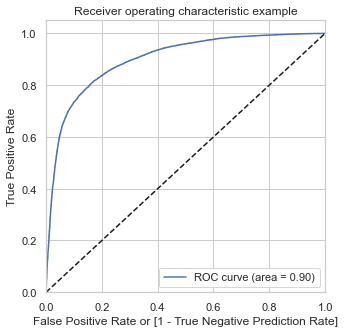

In [112]:
# Plotting the curve for the obtained metrics
draw_roc(y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob)

In [113]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_sm_pred_final[i]= y_train_sm_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_sm_pred_final.head()

Converted  Converted_prob  churn_pred  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
0         0        0.013059           0    1    0    0    0    0    0    0   
1         1        0.094485           0    1    0    0    0    0    0    0   
2         0        0.410164           0    1    1    1    1    1    0    0   
3         0        0.013443           0    1    0    0    0    0    0    0   
4         0        0.668661           1    1    1    1    1    1    1    1   

   0.7  0.8  0.9  
0    0    0    0  
1    0    0    0  
2    0    0    0  
3    0    0    0  
4    0    0    0

In [114]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['probability','accuracy','sensitivity','specificity'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensitivity,specificity]
print(cutoff_df)

     probability  accuracy  sensitivity  specificity
0.0          0.0  0.500000     1.000000     0.000000
0.1          0.1  0.689125     0.976359     0.401891
0.2          0.2  0.752137     0.948491     0.555783
0.3          0.3  0.786075     0.911529     0.660620
0.4          0.4  0.808079     0.874432     0.741726
0.5          0.5  0.819763     0.830060     0.809465
0.6          0.6  0.821399     0.778460     0.864339
0.7          0.7  0.814103     0.719404     0.908802
0.8          0.8  0.783006     0.617931     0.948081
0.9          0.9  0.637570     0.290235     0.984906


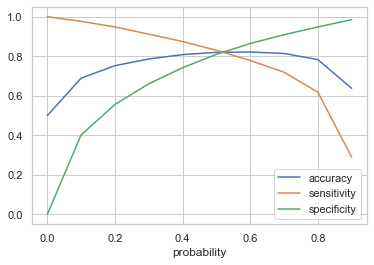

In [115]:
# plotting accuracy sensitivity and specificity for various probabilities calculated above.
cutoff_df.plot.line(x='probability', y=['accuracy','sensitivity','specificity'])
plt.show()

In [116]:
# Let's create columns with refined probability cutoffs 
numbers = [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59]
for i in numbers:
    y_train_sm_pred_final[i]= y_train_sm_pred_final.Converted_prob.map(lambda x: 1 if x > i else 0)
y_train_sm_pred_final.head()

Converted  Converted_prob  churn_pred  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
0         0        0.013059           0    1    0    0    0    0    0    0   
1         1        0.094485           0    1    0    0    0    0    0    0   
2         0        0.410164           0    1    1    1    1    1    0    0   
3         0        0.013443           0    1    0    0    0    0    0    0   
4         0        0.668661           1    1    1    1    1    1    1    1   

   0.7  0.8  0.9  0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59  
0    0    0    0     0     0     0     0     0     0     0     0     0  
1    0    0    0     0     0     0     0     0     0     0     0     0  
2    0    0    0     0     0     0     0     0     0     0     0     0  
3    0    0    0     0     0     0     0     0     0     0     0     0  
4    0    0    0     1     1     1     1     1     1     1     1     1

In [117]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['probability','accuracy','sensitivity','specificity'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.50,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensitivity,specificity]
print(cutoff_df)

      probability  accuracy  sensitivity  specificity
0.50         0.50  0.819763     0.830060     0.809465
0.51         0.51  0.820195     0.824832     0.815557
0.52         0.52  0.821058     0.820104     0.822013
0.53         0.53  0.822513     0.816376     0.828651
0.54         0.54  0.822127     0.810193     0.834061
0.55         0.55  0.822309     0.804919     0.839698
0.56         0.56  0.821627     0.798372     0.844881
0.57         0.57  0.821081     0.793190     0.848973
0.58         0.58  0.821649     0.788598     0.854701
0.59         0.59  0.821422     0.783688     0.859156


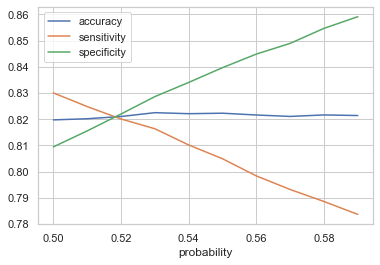

In [118]:
# plotting accuracy sensitivity and specificity for various probabilities calculated above.
cutoff_df.plot.line(x='probability', y=['accuracy','sensitivity','specificity'])
plt.show()

### From the above graph we can conclude, the optimal cutoff point in the probability to define the predicted churn variabe converges at 0.518

In [119]:
#### From the curve above,we can take 0.518 is the optimum point to take it as a cutoff probability.

y_train_sm_pred_final['final_churn_pred'] = y_train_sm_pred_final.Converted_prob.map( lambda x: 1 if x > 0.518 else 0)

y_train_sm_pred_final.head()

Converted  Converted_prob  churn_pred  0.0  0.1  0.2  0.3  0.4  0.5  0.6  \
0         0        0.013059           0    1    0    0    0    0    0    0   
1         1        0.094485           0    1    0    0    0    0    0    0   
2         0        0.410164           0    1    1    1    1    1    0    0   
3         0        0.013443           0    1    0    0    0    0    0    0   
4         0        0.668661           1    1    1    1    1    1    1    1   

   0.7  0.8  0.9  0.51  0.52  0.53  0.54  0.55  0.56  0.57  0.58  0.59  \
0    0    0    0     0     0     0     0     0     0     0     0     0   
1    0    0    0     0     0     0     0     0     0     0     0     0   
2    0    0    0     0     0     0     0     0     0     0     0     0   
3    0    0    0     0     0     0     0     0     0     0     0     0   
4    0    0    0     1     1     1     1     1     1     1     1     1   

   final_churn_pred  
0                 0  
1                 0  
2                 0  
3                 0  
4                 1

In [120]:
confusion2 = metrics.confusion_matrix(y_train_sm_pred_final.Converted, y_train_sm_pred_final.final_churn_pred )
print(confusion2)

[[18062  3934]
 [ 3941 18055]]


In [121]:
TP2 = confusion2[1,1] # true positive 
TN2 = confusion2[0,0] # true negatives
FP2 = confusion2[0,1] # false positives
FN2 = confusion2[1,0] # false negatives

print('The metrics for test data:--')

# Calculating the ovearall accuracy again
print("Accuracy =",metrics.accuracy_score(y_train_sm_pred_final.Converted, y_train_sm_pred_final.final_churn_pred))

# Let's see the sensitivity of our logistic regression model
print("Sensitivity = ",TP2 / float(TP2+FN2))

# Let us calculate specificity
print("Specificity = ",TN2 / float(TN2+FP2))

# Calculate false postive rate - predicting churn when customer does not have churned
print("False Positive Rate = ",FP2/ float(TN2+FP2))

# positive predictive value 
print ("Precision = ",TP2 / float(TP2+FP2))

# Negative predictive value
print ("True Negative Prediction Rate = ",TN2 / float(TN2 + FN2))

The metrics for test data:--
Accuracy = 0.8209901800327333
Sensitivity =  0.8208310601927623
Specificity =  0.8211492998727041
False Positive Rate =  0.17885070012729587
Precision =  0.8210923643640001
True Negative Prediction Rate =  0.8208880607189929


In [122]:
from sklearn.metrics import precision_recall_curve


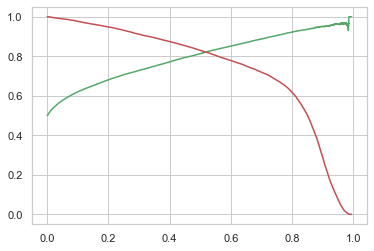

In [123]:
p, r, thresholds = precision_recall_curve(y_train_sm_pred_final.Converted, y_train_sm_pred_final.Converted_prob)

# Plotting the curve
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()


In [124]:
# Scaling the test data
X_test[num_col] = scaler.transform(X_test[num_col])
X_test.head()

onnet_mou_8  offnet_mou_8  loc_og_t2t_mou_8  loc_og_t2m_mou_8  \
48388     0.291988      1.000000          0.054896          0.674125   
29754     0.033810      0.291029          0.112228          0.607638   
50131     0.180709      0.077711          0.575928          0.166279   
66630     0.013790      0.599537          0.045775          0.172327   
91920     0.476793      0.360152          1.000000          0.754800   

       loc_og_t2f_mou_8  loc_og_mou_8  std_og_t2t_mou_8  std_og_t2m_mou_8  \
48388          0.864122      0.453607          0.740709          1.000000   
29754          0.100763      0.414812          0.000000          0.000000   
50131          0.000000      0.242687          0.021537          0.001359   
66630          0.000000      0.120583          0.000000          1.000000   
91920          0.000000      0.856506          0.000000          0.043972   

       std_og_mou_8  spl_og_mou_8  total_og_mou_8  loc_ic_t2t_mou_8  \
48388      0.728485      0.000000        0.539751          0.110707   
29754      0.000000      0.229967        0.174186          0.118427   
50131      0.005162      0.000000        0.101059          1.000000   
66630      0.547173      1.000000        0.341387          0.072947   
91920      0.014489      0.295114        0.357312          0.875109   

       loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  loc_ic_mou_8  std_ic_t2t_mou_8  \
48388          0.479205          0.082437      0.344208          1.000000   
29754          1.000000          1.000000      0.971465          0.000000   
50131          0.495038          0.079211      0.590053          0.890085   
66630          0.392990          0.315054      0.288624          1.000000   
91920          0.413516          0.018280      0.480387          0.000000   

       std_ic_t2m_mou_8  std_ic_mou_8  total_ic_mou_8  total_rech_num_8  \
48388          1.000000      1.000000        0.904114          0.452830   
29754          0.017041      0.009755        0.781541          0.264151   
50131          0.369950      0.402580        0.521360          0.792453   
66630          1.000000      1.000000        1.000000          0.603774   
91920          0.056986      0.032622        0.406969          0.301887   

       max_rech_amt_8  last_day_rch_amt_8  max_rech_data_8       aon  \
48388        1.000000            0.769231         0.000000  0.020455   
29754        0.664286            0.000000         0.464935  1.000000   
50131        0.119048            0.076923         0.064935  0.085795   
66630        0.119048            0.153846         0.059740  0.089489   
91920        0.309524            0.000000         0.000000  0.161932   

       aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  vol_mb_8  total_rech_data_amt_8  \
48388         0.0         0.0         0.0  0.000000               0.000000   
29754         0.0         0.0         0.0  0.759212               0.232468   
50131         1.0         1.0         1.0  0.584210               1.000000   
66630         0.0         0.0         0.0  0.000304               0.029870   
91920         0.0         0.0         0.0  0.000000               0.000000   

       onnet_mou_avg_67  offnet_mou_avg_67  loc_og_t2t_mou_avg_67  \
48388          0.227406           0.694484               0.000953   
29754          0.022272           0.274351               0.079523   
50131          0.057234           0.031440               0.182899   
66630          0.008348           0.556191               0.019484   
91920          1.000000           0.591674               1.000000   

       loc_og_t2m_mou_avg_67  loc_og_t2f_mou_avg_67  loc_og_mou_avg_67  \
48388               0.223759               0.024576           0.142133   
29754               0.598348               1.000000           0.414867   
50131               0.058063               0.000000           0.081188   
66630               0.164088               0.000000           0.108530   
91920               1.000000               0.000000           1.000000   

       s

In [125]:
#Feature selection
X_test=X_test[col]
X_test.head()

loc_og_t2t_mou_8  loc_ic_t2t_mou_8  loc_ic_t2m_mou_8  loc_ic_t2f_mou_8  \
48388          0.054896          0.110707          0.479205          0.082437   
29754          0.112228          0.118427          1.000000          1.000000   
50131          0.575928          1.000000          0.495038          0.079211   
66630          0.045775          0.072947          0.392990          0.315054   
91920          1.000000          0.875109          0.413516          0.018280   

       total_rech_num_8  last_day_rch_amt_8       aon  vol_mb_8  \
48388          0.452830            0.769231  0.020455  0.000000   
29754          0.264151            0.000000  1.000000  0.759212   
50131          0.792453            0.076923  0.085795  0.584210   
66630          0.603774            0.153846  0.089489  0.000304   
91920          0.301887            0.000000  0.161932  0.000000   

       total_rech_data_amt_8  total_ic_mou_avg_67  total_rech_num_avg_67  \
48388               0.000000             0.318024               0.384615   
29754               0.232468             0.750139               0.230769   
50131               1.000000             0.330825               0.826923   
66630               0.029870             1.000000               0.807692   
91920               0.000000             1.000000               0.519231   

       max_rech_amt_avg_67  
48388             1.000000  
29754             0.510086  
50131             0.115274  
66630             0.194524  
91920             0.345821

In [126]:
# Adding constant to the test model.
X_test_SM = sm.add_constant(X_test)

In [127]:
y_test_pred = result.predict(X_test_SM)
print("\n The first ten probability value of the prediction are:\n",y_test_pred[:10])


 The first ten probability value of the prediction are:
 48388    0.222403
29754    0.009456
50131    0.005487
66630    0.534729
91920    0.345459
57023    0.022732
3388     0.031681
48874    0.003142
34480    0.031694
63686    0.149421
dtype: float64


In [128]:
y_pred = pd.DataFrame(y_test_pred)
y_pred.head()

0
48388  0.222403
29754  0.009456
50131  0.005487
66630  0.534729
91920  0.345459

In [129]:
y_pred=y_pred.rename(columns = {0:"Conv_prob"})


In [130]:
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

churn
48388     0
29754     0
50131     0
66630     0
91920     0

In [131]:
y_pred_final = pd.concat([y_test_df,y_pred],axis=1)
y_pred_final.head()

churn  Conv_prob
48388     0   0.222403
29754     0   0.009456
50131     0   0.005487
66630     0   0.534729
91920     0   0.345459

In [132]:
y_pred_final['test_churn_pred'] = y_pred_final.Conv_prob.map(lambda x: 1 if x>0.54 else 0)
y_pred_final.head()

churn  Conv_prob  test_churn_pred
48388     0   0.222403                0
29754     0   0.009456                0
50131     0   0.005487                0
66630     0   0.534729                0
91920     0   0.345459                0

In [133]:
# Confusion Matrix
confusion2_test = metrics.confusion_matrix(y_pred_final.churn, y_pred_final.test_churn_pred)
print("Confusion Matrix\n",confusion2_test)

Confusion Matrix
 [[4599  925]
 [  89  378]]


In [134]:
# Calculating model validation parameters
TP3 = confusion2_test[1,1] # true positive 
TN3 = confusion2_test[0,0] # true negatives
FP3 = confusion2_test[0,1] # false positives
FN3 = confusion2_test[1,0] # false negatives

In [135]:
print('The metrics for test data:--')

# Checking the overall accuracy of the predicted set.
print("Accuracy =", metrics.accuracy_score(y_pred_final.churn, y_pred_final.test_churn_pred))

# Let's see the sensitivity of our logistic regression model
print("Sensitivity = ",TP3 / float(TP3+FN3))

# Let us calculate specificity
print("Specificity = ",TN3 / float(TN3+FP3))

# Calculate false postive rate - predicting churn when customer does not have churned
print("False Positive Rate = ",FP3/ float(TN3+FP3))

# positive predictive value 
print ("Precision = ",TP3 / float(TP3+FP3))

# Negative predictive value
print ("True Negative Prediction Rate = ",TN3 / float(TN3+FN3))


The metrics for test data:--
Accuracy = 0.8307461191787682
Sensitivity =  0.8094218415417559
Specificity =  0.8325488776249095
False Positive Rate =  0.16745112237509052
Precision =  0.2900997697620875
True Negative Prediction Rate =  0.9810153583617748


In [136]:
acc1 = round(metrics.accuracy_score(y_pred_final.churn, y_pred_final.test_churn_pred),2)*100
sen1 = round(TP3 / float(TP3+FN3),2)*100
spe1 = round(TN3 / float(TN3+FP3),2)*100

print("The accuracy of the predicted model is: ",acc1,"%")
print("The sensitivity of the predicted model is: ",sen1,"%")

print("\nAs the model created is based on a sentivity model, i.e. the True positive rate is given more importance as the actual and prediction of churn by a customer\n")

The accuracy of the predicted model is:  83.0 %
The sensitivity of the predicted model is:  81.0 %

As the model created is based on a sentivity model, i.e. the True positive rate is given more importance as the actual and prediction of churn by a customer



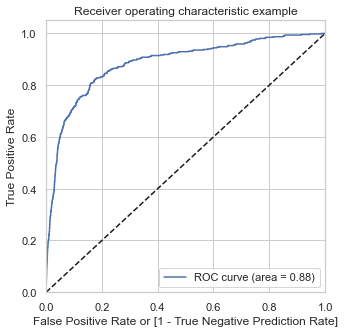

In [137]:
# ROC curve for the test dataset

# Defining the variables to plot the curve
fpr, tpr, thresholds = metrics.roc_curve(y_pred_final.churn,y_pred_final.Conv_prob, drop_intermediate = False )
# Plotting the curve for the obtained metrics
draw_roc(y_pred_final.churn,y_pred_final.Conv_prob)

***Summary:--***
    
- Train Data
    - Accuracy = 82.09%
    - Sensitivity =  82.08%
    - Specificity =  82.14%
- Test Data
    - Accuracy = 83.07%
    - Sensitivity =  80.94%
    - Specificity =  83.25%

In [138]:
# adding the values in dictionary for final analysis
metrics_dict = {'Without PCA: Logistic Reg':{'Accuracy': acc1, 'Sensitivity': sen1, 'Specificity': spe1}}

In [139]:
metrics_dict

{'Without PCA: Logistic Reg': {'Accuracy': 83.0,
  'Sensitivity': 81.0,
  'Specificity': 83.0}}

# 13. Modelling with PCA

In [140]:
# Splitting data into train and test set 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

In [141]:
# Handling class imbalance

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

# Fittign SMOTE to the train set
X_train, y_train = sm.fit_resample(X_train, y_train)

In [142]:
# Standardization method
from sklearn.preprocessing import StandardScaler

# Instantiate the Scaler
scaler = StandardScaler() 

# List of the numeric columns
cols_scale = X_train.columns.to_list()     

# Fit the data into scaler and transform
X_train[cols_scale] = scaler.fit_transform(X_train[cols_scale])
X_test[cols_scale] = scaler.transform(X_test[cols_scale])



In [143]:
#Import PCA
from sklearn.decomposition import PCA

# Instantiate PCA
pca = PCA(random_state=42) 

# Fit train set on PCA
pca.fit(X_train)

# Principal components
pca.components_

array([[ 0.1343965 ,  0.181168  ,  0.20745422, ...,  0.00380986,
        -0.02014262, -0.04903054],
       [-0.15558117, -0.10210556,  0.02592697, ...,  0.21902607,
         0.20949233,  0.17345152],
       [ 0.13610965,  0.09546145, -0.03718599, ...,  0.19688369,
         0.21370805,  0.14839257],
       ...,
       [ 0.06227247,  0.01216975,  0.14987443, ..., -0.00733197,
         0.0023869 ,  0.00025258],
       [-0.09369172,  0.00540413, -0.08081519, ...,  0.00258045,
         0.0005896 ,  0.00163762],
       [-0.03428364, -0.00547327, -0.06318968, ...,  0.00143903,
         0.00061083,  0.00147894]])

In [144]:
# Cumuliative varinace of the PCs
variance_cumu = np.cumsum(pca.explained_variance_ratio_)
print(variance_cumu)

[0.24412776 0.41513187 0.50540431 0.55973774 0.60939339 0.65290628
 0.69178051 0.7181411  0.74025061 0.7616856  0.78070857 0.79958128
 0.81499224 0.83018797 0.84320944 0.8549945  0.86614709 0.87666383
 0.88681402 0.89664905 0.9054498  0.91404889 0.92116819 0.92730595
 0.93321557 0.93844056 0.94361052 0.94853761 0.95312353 0.95754158
 0.96157539 0.96550424 0.96925476 0.97286483 0.97620558 0.97940472
 0.98204084 0.98453226 0.98653166 0.98850853 0.99023011 0.9917667
 0.9932677  0.99462921 0.9956316  0.99637987 0.99710696 0.9977535
 0.99835822 0.99885648 0.99931647 0.99964948 0.99984759 1.        ]


Text(0, 0.5, 'Cumulative Variance')

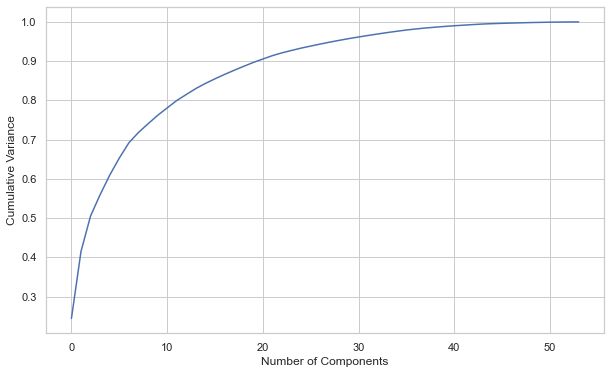

In [145]:
# Plotting scree plot
fig = plt.figure(figsize = (10,6))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

In [146]:
X_train.shape

(43992, 54)

In [147]:
# Performing PCA with 30 components

# Importing incremental PCA
from sklearn.decomposition import IncrementalPCA

# Instantiate PCA with 30 components
pca_final = IncrementalPCA(n_components=30)

# Fit and transform the X_train
X_train_pca = pca_final.fit_transform(X_train)
X_test_pca = pca_final.transform(X_test)

### 13.1 Logistic Regression

In [148]:
# Importing scikit logistic regression module
from sklearn.linear_model import LogisticRegression

# Impoting metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [149]:
# Creating KFold object with 5 splits
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_pca, y_train)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [151]:
# results of grid search CV
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.087900      0.006546         0.003600        0.000592    0.01   
1       0.085690      0.006271         0.003338        0.000380     0.1   
2       0.088402      0.005420         0.003512        0.000449       1   
3       0.088435      0.007263         0.003137        0.000242      10   
4       0.087793      0.003842         0.003307        0.000317     100   
5       0.089701      0.005921         0.003533        0.000427    1000   

        params  split0_test_score  split1_test_score  split2_test_score  \
0  {'C': 0.01}           0.829871           0.837954           0.825632   
1   {'C': 0.1}           0.830332           0.837052           0.826087   
2     {'C': 1}           0.830332           0.837052           0.826087   
3    {'C': 10}           0.830332           0.837052           0.826087   
4   {'C': 100}           0.830332           0.837052           0.826087   
5  {'C': 1000}           0.830332           0.837052           0.826087   

   split3_test_score  split4_test_score  mean_test_score  std_test_score  \
0           0.825205           0.827710         0.829274        0.004647   
1           0.825205           0.828385         0.829412        0.004220   
2           0.825205           0.828385         0.829412        0.004220   
3           0.825205           0.828385         0.829412        0.004220   
4           0.825205           0.828385         0.829412        0.004220   
5           0.825205           0.828385         0.829412        0.004220   

   rank_test_score  split0_train_score  split1_train_score  \
0                6            0.829654            0.828065   
1                1            0.829880            0.828749   
2                1            0.829993            0.828635   
3                1            0.830050            0.828635   
4                1            0.830050            0.828635   
5                1            0.830050            0.828635   

   split2_train_score  split3_train_score  split4_train_score  \
0            0.830086            0.828885            0.829231   
1            0.830256            0.829850            0.829402   
2            0.830199            0.829850            0.829402   
3            0.830199            0.829850            0.829402   
4            0.830199            0.829793            0.829402   
5            0.830199            0.829793            0.829402   

   mean_train_score  std_train_score  
0          0.829184         0.000689  
1          0.829627         0.000516  
2          0.829616         0.000556  
3          0.829627         0.000564  
4          0.829616         0.000560  
5          0.829616         0.000560

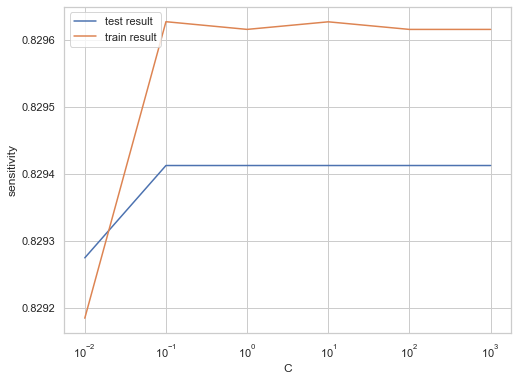

In [152]:
# plot of C versus train and validation scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')


In [153]:
# Best score with best C
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test sensitivity is {0} at C = {1}".format(best_score, best_C))

 The highest test sensitivity is 0.8294123197513518 at C = 0.1


In [154]:
# Instantiate the model with best C
logistic_pca = LogisticRegression(C=best_C) 

# Fit the model on the train set
log_pca_model = logistic_pca.fit(X_train_pca, y_train)

In [155]:
# Predictions on the train set
y_train_pred = log_pca_model.predict(X_train_pca)

In [156]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives


[[18107  3889]
 [ 3749 18247]]


In [157]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8263775231860339
Sensitivity:- 0.8295599199854519
Specificity:- 0.8231951263866157


In [158]:
# Predictions on the test set
y_test_pred = log_pca_model.predict(X_test_pca)

In [159]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

[[4517 1007]
 [  86  381]]


In [160]:
# Accuracy
acc2 = round(metrics.accuracy_score(y_test, y_test_pred),2) * 100
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
sen2 = round(TP / float(TP+FN),2) * 100
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
spe2 = round(TN / float(TN+FP),2) * 100
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8175596728425972
Sensitivity:- 0.815845824411135
Specificity:- 0.8177045619116582


***Model summary***

- Train set
    - Accuracy = 82.6%
    - Sensitivity = 82.95%
    - Specificity = 82.31%
- Test set
    - Accuracy = 81.75%
    - Sensitivity = 81.58%
    - Specificity = 81.77%
    
Overall, the model is performing well in the test set as well.

In [161]:
# adding the values in dictionary for final analysis
metrics_dict.update({'With PCA: Logistic Reg':{'Accuracy': acc2, 'Sensitivity': sen2, 'Specificity': spe2}})

In [162]:
metrics_dict

{'Without PCA: Logistic Reg': {'Accuracy': 83.0,
  'Sensitivity': 81.0,
  'Specificity': 83.0},
 'With PCA: Logistic Reg': {'Accuracy': 82.0,
  'Sensitivity': 82.0,
  'Specificity': 82.0}}

### 13.2 Decision Tree

In [163]:
# Importing decision tree classifier
from sklearn.tree import DecisionTreeClassifier

***Hyperparameter Tuning***

In [164]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'recall',
                           cv = 5, 
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_pca,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='recall', verbose=1)

In [165]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.575633      0.009360         0.004338        0.000423   
1       0.573776      0.009480         0.004615        0.000378   
2       0.572367      0.007857         0.003850        0.000174   
3       0.561503      0.003478         0.003818        0.000408   
4       0.968889      0.009132         0.004509        0.000710   
5       0.974032      0.010500         0.004253        0.000315   
6       0.944809      0.012203         0.004082        0.000379   
7       0.951020      0.008526         0.004648        0.000311   

  param_max_depth param_min_samples_leaf param_min_samples_split  \
0               5                     50                      50   
1               5                     50                     100   
2               5                    100                      50   
3               5                    100                     100   
4              10                     50                      50   
5              10                     50                     100   
6              10                    100                      50   
7              10                    100                     100   

                                              params  split0_test_score  \
0  {'max_depth': 5, 'min_samples_leaf': 50, 'min_...           0.801318   
1  {'max_depth': 5, 'min_samples_leaf': 50, 'min_...           0.801318   
2  {'max_depth': 5, 'min_samples_leaf': 100, 'min...           0.799955   
3  {'max_depth': 5, 'min_samples_leaf': 100, 'min...           0.799955   
4  {'max_depth': 10, 'min_samples_leaf': 50, 'min...           0.819277   
5  {'max_depth': 10, 'min_samples_leaf': 50, 'min...           0.819277   
6  {'max_depth': 10, 'min_samples_leaf': 100, 'mi...           0.781314   
7  {'max_depth': 10, 'min_samples_leaf': 100, 'mi...           0.781314   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.839318           0.846101           0.825870           0.815867   
1           0.839318           0.846101           0.825870           0.815413   
2           0.838636           0.843373           0.824960           0.810184   
3           0.838636           0.843373           0.824960           0.810184   
4           0.829318           0.839509           0.834053           0.836554   
5           0.829318           0.839509           0.834053           0.835644   
6           0.824545           0.828370           0.817913           0.822232   
7           0.824545           0.828370           0.817913           0.822232   

   mean_test_score  std_test_score  rank_test_score  
0         0.825695        0.016080                3  
1         0.825604        0.016137                4  
2         0.823422        0.016479                5  
3         0.823422        0.016479                5  
4         0.831742        0.007072                1  
5         0.831560        0.006957                2  
6         0.814875        0.017119                7  
7         0.814875        0.017119                7

In [166]:
# Printing the optimal sensitivity score and hyperparameters
print("Best sensitivity:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best sensitivity:- 0.8317422451383578
DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50)


***Model with optimal hyperparameters***

In [167]:
# Model with optimal hyperparameters
dt_pca_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

dt_pca_model.fit(X_train_pca, y_train)


DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50,
                       random_state=100)

***Prediction on Train Data***

In [168]:
# Predictions on the train set
y_train_pred = dt_pca_model.predict(X_train_pca)

In [169]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)

[[18582  3414]
 [ 2892 19104]]


In [170]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print("The metrics values on train data:--")

# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

The metrics values on train data:--
Accuracy:- 0.8566557555919257
Sensitivity:- 0.8685215493726132
Specificity:- 0.8447899618112384


***Prediction on Test Data***

In [171]:
# Prediction on the test set
y_test_pred = dt_pca_model.predict(X_test_pca)

In [172]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[4589  935]
 [ 132  335]]


In [173]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print("The metrics values on test data:--")

# Accuracy
acc3 = round(metrics.accuracy_score(y_test, y_test_pred),2) * 100
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
sen3 = round(TP / float(TP+FN),2) * 100
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
spe3 = round(TN / float(TN+FP),2) * 100
print("Specificity:-", TN / float(TN+FP))



The metrics values on test data:--
Accuracy:- 0.8218995159405775
Sensitivity:- 0.7173447537473233
Specificity:- 0.8307385952208545


***Model summary***

- Train set
    - Accuracy = 85.66%
    - Sensitivity = 86.85%
    - Specificity = 84.47%
- Test set
    - Accuracy = 82.18%
    - Sensitivity = 71.73%
    - Specificity = 83.07%
    
We can see from the model performance that the Sensitivity has decreased while evaluating the model on the test data. 
However, the accuracy and specificity is quite good in the test data.

In [174]:
# adding the values in dictionary for final analysis
metrics_dict.update({'With PCA: Decision Tree':{'Accuracy': acc3, 'Sensitivity': sen3, 'Specificity': spe3}})

In [175]:
metrics_dict

{'Without PCA: Logistic Reg': {'Accuracy': 83.0,
  'Sensitivity': 81.0,
  'Specificity': 83.0},
 'With PCA: Logistic Reg': {'Accuracy': 82.0,
  'Sensitivity': 82.0,
  'Specificity': 82.0},
 'With PCA: Decision Tree': {'Accuracy': 82.0,
  'Sensitivity': 72.0,
  'Specificity': 83.0}}

### 13.3 Random Forest Classifier

In [176]:
# Importing random forest classifier
from sklearn.ensemble import RandomForestClassifier

***Hyperparameter Tuning***

In [177]:
param_grid = {
    'max_depth': range(5,10,5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
    'n_estimators': [100,200,300], 
    'max_features': [10, 20]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1,
                           verbose = 1, 
                           return_train_score=True)

# Fit the model
grid_search.fit(X_train_pca, y_train)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(5, 10, 5), 'max_features': [10, 20],
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50),
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, verbose=1)

In [178]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8222404073467904 using {'max_depth': 5, 'max_features': 20, 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 300}


***Model with Optimal Hyperparameters***

In [179]:
# model with the best hyperparameters

rfc_model = RandomForestClassifier(bootstrap=True,
                             max_depth=5,
                             min_samples_leaf=50, 
                             min_samples_split=100,
                             max_features=20,
                             n_estimators=300)

# Fit the model
rfc_model.fit(X_train_pca, y_train)


RandomForestClassifier(max_depth=5, max_features=20, min_samples_leaf=50,
                       min_samples_split=100, n_estimators=300)

***Prediction on Train Data***

In [180]:
# Predictions on the train set
y_train_pred = rfc_model.predict(X_train_pca)

In [181]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)

[[19716  2280]
 [ 5449 16547]]


In [182]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print("Metrics on Train Data:--")

# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))


Metrics on Train Data:--
Accuracy:- 0.8243089652664121
Sensitivity:- 0.7522731405710129
Specificity:- 0.8963447899618112


***Prediction on Test Data***

In [183]:
# Prediction on the test set
y_test_pred = rfc_model.predict(X_test_pca)

In [184]:
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[4961  563]
 [ 141  326]]


In [185]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

print("Metrics on Test Data:--")

# Accuracy
acc4 = round(metrics.accuracy_score(y_test, y_test_pred),2) * 100
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
sen4 = round(TP / float(TP+FN),2) * 100
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
spe4 = round(TN / float(TN+FP),2) * 100
print("Specificity:-", TN / float(TN+FP))


Metrics on Test Data:--
Accuracy:- 0.8824904022700718
Sensitivity:- 0.6980728051391863
Specificity:- 0.8980811006517017


***Model summary***

- Train set
    - Accuracy = 83.67%
    - Sensitivity = 77.97%
    - Specificity = 89.37%
- Test set
    - Accuracy = 88.05%
    - Sensitivity = 73.66%
    - Specificity = 89.2%

We can see from the model performance that the Sensitivity has been decreased while evaluating the model on the test data. However, the accuracy and specificity is quite good in the test data.

In [186]:
# adding the values in dictionary for final analysis
metrics_dict.update({'With PCA: Random Forest':{'Accuracy': acc4, 'Sensitivity': sen4, 'Specificity': spe4}})

# 14. Final Analysis across all models

In [187]:
metrics_data = pd.DataFrame(metrics_dict)
metrics_data

Without PCA: Logistic Reg  With PCA: Logistic Reg  \
Accuracy                          83.0                    82.0   
Sensitivity                       81.0                    82.0   
Specificity                       83.0                    82.0   

             With PCA: Decision Tree  With PCA: Random Forest  
Accuracy                        82.0                     88.0  
Sensitivity                     72.0                     70.0  
Specificity                     83.0                     90.0

***Inference:--***

- It is more important to identify churners than the non-churners accurately and thus focus is on the ***sensitivity*** parameter, along with accuracy.
- Hence, we conclude that ***basic logistic regression model is performing better*** compared to other PCA classifier models. 

### 14.1 Predictor Variables 

|Variable                |   coef  | Description                                                        |  
| ---------------------- | ------- | ------------------------------------------------------------------ |         
|total_rech_num_8        |  -3.4330| total no of recharge in action phase                               |
|                        |         |                                                                    |
|loc_ic_t2m_mou_8        |  -3.2919| local incoming calls minutes from other operator in action phase   |
|                        |         |                                                                    |
|last_day_rch_amt_8      |  -1.9146| recharge amount done on last day of action phase                   |
|                        |         |                                                                    |
|loc_ic_t2t_mou_8        |  -1.5342| local incoming calls minutes within same operator in action phase  |
|                        |         |                                                                    |
|vol_mb_8                |  -1.4645| mobile internet (2g + 3g) usage in action phase                    |
|                        |         |                                                                    |
|loc_ic_t2f_mou_8        |  -1.1425| local incoming calls minutes from fixed lines in action phase      |
|                        |         |                                                                    |
|total_rech_data_amt_8   |  -1.1338| total recharge for mobile data internet usage in action phase      |
|                        |         |                                                                    |
|aon                     |  -0.9889| age on network                                                     |
|                        |         |                                                                    |
|loc_og_t2t_mou_8        |  -0.7582| local outgoing calls minutes within same operator in action phase  |
|                        |         |                                                                    |
|max_rech_amt_avg_67     |   1.3180| maximum recharge done in good phase                                |
|                        |         |                                                                    |
|total_ic_mou_avg_67     |   1.3916| total incoming calls minutes in good phase                         |
|                        |         |                                                                    |
|total_rech_num_avg_67   |   2.0402| total no of recharge in good phase                                 | 
|                        |         |

### Inference:-

We can see most of the top variables have negative coefficients. That means, the variables are inversely correlated with the churn probablity.

***There is a high chance that the customer is likely to churn,*** 
- If the total recharge number (total_rech_num_8) is lesser in the month of August (action phase) than June & July (good phase).
- If local incoming calls (minutes) is lesser from other operator in action phase than good phase.
- If recharge amount done on last day of action phase is lesser than good phase.
- If local incoming calls (minutes) is lesser within same operator in action phase than good phase.
- If mobile internet (2g + 3g) usage in action phase is lesser than good phase.
- If local incoming calls (minutes) from fixed lines in action phase is lesser than good phase.
- If total recharge for mobile data internet usage in action phase is lesser than good phase.
- If age on network is lesser.
- If local outgoing calls (minutes) within same operator in action phase is lesser than good phase.
- If maximum recharge done in good phase is more than the action phase.
- If overall total incoming calls (minutes) in good phase is more than the action phase.
- If overall total no of recharge in good phase is more than the action phase.

In [188]:
# Creating churn dataframe
data_churn = churn[churn['churn'] == 1]
# Creating not churn dataframe
data_non_churn = churn[churn['churn'] == 0]


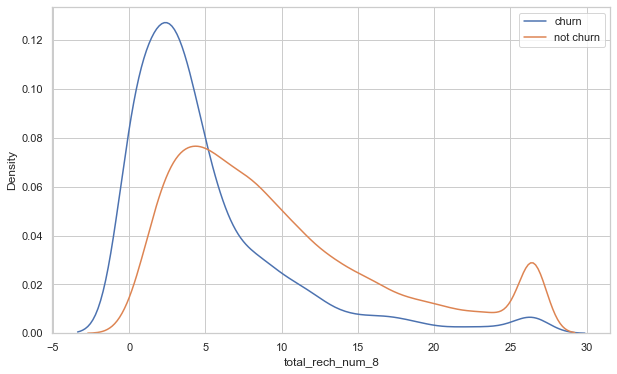

In [189]:
# Plotting "total_rech_num_8" predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['total_rech_num_8'],label='churn',hist=False)
sns.distplot(data_non_churn['total_rech_num_8'],label='not churn',hist=False)
plt.legend(loc="upper right")
plt.show()


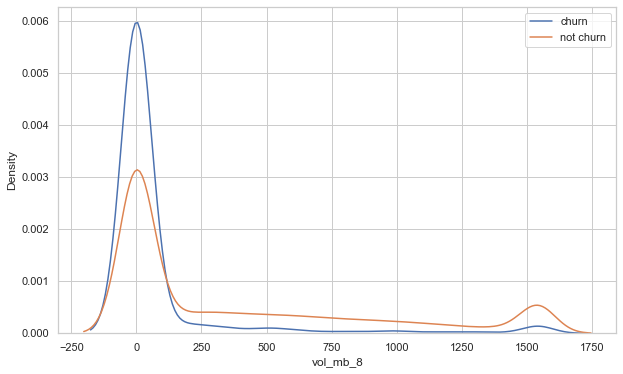

In [190]:
# Plotting "vol_mb_8" predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['vol_mb_8'],label='churn',hist=False)
sns.distplot(data_non_churn['vol_mb_8'],label='not churn',hist=False)
plt.legend(loc="upper right")
plt.show()

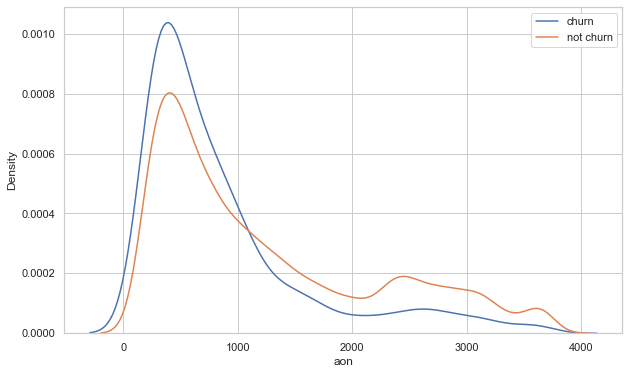

In [191]:
# Plotting "aon" predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['aon'],label='churn',hist=False)
sns.distplot(data_non_churn['aon'],label='not churn',hist=False)
plt.legend(loc="upper right")
plt.show()

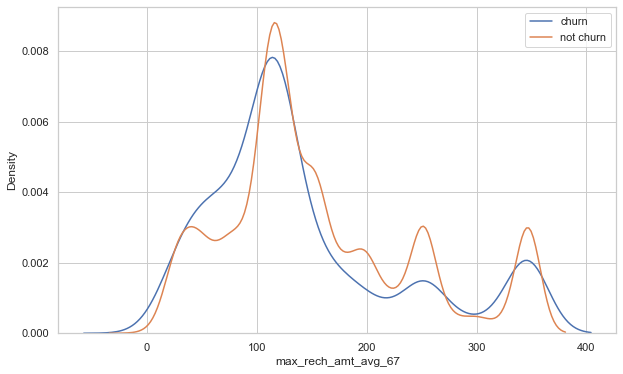

In [192]:
# Plotting "max_rech_amt_avg_67" predictor for churn and not churn customers
fig = plt.figure(figsize=(10,6))
sns.distplot(data_churn['max_rech_amt_avg_67'],label='churn',hist=False)
sns.distplot(data_non_churn['max_rech_amt_avg_67'],label='not churn',hist=False)
plt.legend(loc="upper right")
plt.show()

## Recommendations

-	Target the customers, whose Average revenue is decreasing.
-	The incoming calls (with local same operator mobile/other operator mobile/fixed lines, STD or Special) plays a vital role in understanding the possibility of churn. Hence, the operator should focus on incoming calls data and has to provide some kind of special offers to the customers whose incoming calls turning lower.
-	Target the customers, which are not the night pack users.
-	Telecom company needs to pay attention to the roaming rates. They need to provide good offers to the customers who are using services from a roaming zone.
-	The company needs to focus on the STD and ISD rates, by providing them with some kind of STD and ISD packages.
-	Company needs to focus on the monthly and sachet schemes to get more small scale business.